In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!nvidia-smi

Fri Aug 14 10:32:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#%cd /content/gdrive/My\ Drive/music_class/music-genre
!pip install efficientnet_pytorch
#!wget http://opihi.cs.uvic.ca/sound/genres.tar.gz -P /content/gdrive/My\ Drive/music_class/music-genre
!cp  /content/gdrive/My\ Drive/music_class/music-genre/genres.tar.gz  /content/sample_data
!tar xvzf /content/sample_data/genres.tar.gz

In [ ]:
import torch
torch.manual_seed(1234)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import numpy as np
np.random.seed(0)
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
#import data_manager
from efficientnet_pytorch import EfficientNet
#from src.CNN2D.model.custom_upchannel import *
import os
from sklearn.model_selection import train_test_split
import random
from torch.utils.data import Dataset, DataLoader
import librosa
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import transforms as T
from collections import OrderedDict
import seaborn as sns
from sklearn.manifold import TSNE

tsne = TSNE()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def readfile(file_name):    
    y = np.load(file_name)
    return y

def readaudio(file_name):
    y, sr = librosa.load(file_name)
    return y, sr

def get_mean_of_list(L):
    return sum(L) / len(L)


def change_pitch(data, sr):
    y_pitch = data.copy()
    bins_per_octave = 12
    pitch_pm = 5
    pitch_change = pitch_pm * 2 * (np.random.uniform())
    y_pitch = librosa.effects.pitch_shift(y_pitch.astype('float64'), sr, n_steps=pitch_change,
                                          bins_per_octave=bins_per_octave)
    return y_pitch

def change_speed(data):
    y_speed = data.copy()
    speed_change = np.random.uniform(low=0.5, high=1.8)
    tmp = librosa.effects.time_stretch(y_speed.astype('float64'), speed_change)
    minlen = min(y_speed.shape[0], tmp.shape[0])
    y_speed *= 0
    y_speed[0:minlen] = tmp[0:minlen]
    return y_speed

def melspectrogram(y, hparams):
    
    S = librosa.stft(y, n_fft=hparams.fft_size, hop_length=hparams.hop_size, win_length=hparams.win_size)

    mel_basis = librosa.filters.mel(hparams.sample_rate, n_fft=hparams.fft_size, n_mels=hparams.num_mels)
    mel_S = np.dot(mel_basis, np.abs(S))
    mel_S = np.log10(1+10*mel_S)
    mel_S = mel_S.T

    return mel_S

def resize_array(array, length):
    resize_array = np.zeros((length, array.shape[1]))
    if array.shape[0] >= length:
        resize_array = array[:length]
    else:
        resize_array[:array.shape[0]] = array
    return resize_array

def feature_extractor(song):
        feature = melspectrogram(song, hparams)
        feature = resize_array(feature, hparams.feature_length)  
        return feature 
def stacker(x):
  b = x.repeat(1, 3, 1, 1)
  return b

def file_collector(root_path,final_list):
  for path, subdirs, files in os.walk(root_path):
    for name in files:
      if(name.find(".mf")==-1):
        final_list.append(os.path.join(path, name))

def file_collector1(root_path,final_list):
  for path, subdirs, files in os.walk(root_path):
    for name in files:
      if(name.find(".mf")==-1 and name.find(".npy")!=-1 ):
        final_list.append(os.path.join(path, name))

In [ ]:
path="/content/genres"
pre_list= []
file_collector(path,pre_list)


for i in pre_list:
  y,sr=readaudio(i)
  temp= np.array_split(y,6) 
   
  for j in range(len(temp)):
      final_name =i+str(j)
      np.save(final_name,temp[j].astype(np.float32))

In [ ]:
%cd /content/gdrive/My\ Drive/music_class/music-genre/dataset/train

path="/content/genres"


names= []

file_collector1(path,names)



train_names, test_names = train_test_split(names, train_size=4800, test_size=1200)

train_10= random.sample(train_names, len(train_names) // 10)



mapping = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, "jazz": 5, "metal": 6, "pop":7 ,"reggae": 8,"rock":9  }
inverse_mapping = ['blues', 'classical', 'country', 'disco', 'hiphop', "jazz", "metal", "pop" ,"reggae","rock" ]

labels_train = [mapping[x.split("/")[3]] for x in train_names]
labels_test = [mapping[x.split("/")[3]] for x in test_names]
labels_train_10 = [mapping[x.split("/")[3]] for x in train_10]


/content/gdrive/My Drive/music_class/music-genre/dataset/train


In [ ]:
class HParams(object):
    def __init__(self):
      
        # Feature Parameters
        self.sample_rate=22050
        self.fft_size = 1024
        self.win_size = 1024
        self.hop_size = 512
        self.num_mels = 128
        self.feature_length = 172

        # Training Parameters
        """ self.device = 1  # 0: CPU, 1: GPU0, 2: GPU1, ...
        self.batch_size = 32
        self.num_epochs = 26
        self.learning_rate = 1e-2
        self.stopping_rate = 1e-5
        self.weight_decay = 1e-6
        self.momentum = 0.9
        self.factor = 0.2
        self.patience = 5"""

    
    
hparams = HParams()



In [ ]:
# this is the dataset class

class MyDataset(Dataset):
    def __init__(self, root_dir, filenames,hparams ,labels, mutation=False):
        self.root_dir = root_dir
        self.file_names = filenames
        self.labels = labels
        self.mutation = mutation
        self.sr = 22500
        self.hparams= hparams

    def __len__(self):
        return len(self.file_names)

    def tensorify(self, song):
        res = T.ToTensor()(song)
        #res = T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(res)
        return res

    def mutate_song(self, song):
        res = change_pitch(song,self.sr)
        res = change_speed(song)
        return res    

    def __getitem__(self, idx):
        """ if torch.is_tensor(idx):
            idx = idx.tolist()"""

        song_name = os.path.join(self.root_dir, self.file_names[idx])
        song = readfile(song_name)
        label = self.labels[idx]      
        

        if self.mutation:
            song1 = self.mutate_song(song)
            song1_f = feature_extractor(song)
            song1_f = self.tensorify(song1_f)
            song2 = self.mutate_song(song)
            song2_f = feature_extractor(song2)
            song2_f = self.tensorify(song2_f)
            sample = {'song1': song1_f, 'song2': song2_f, 'label': label}
        else:
            song_f =  feature_extractor(song)
            song_f = self.tensorify(song_f)
            sample = {'song': song_f, 'label': label}

        return sample


In [ ]:
training_dataset_mutated = MyDataset(" ", train_names,hparams, labels_train, mutation=True)
training_dataset = MyDataset(" ", train_10,hparams, labels_train_10, mutation=False)
testing_dataset = MyDataset("", test_names,hparams, labels_test, mutation=False)

In [ ]:
dataloader_training_dataset_mutated = DataLoader(training_dataset_mutated, batch_size=64, shuffle=True, num_workers=48)
dataloader_training_dataset = DataLoader(training_dataset, batch_size=48, shuffle=True, num_workers=48)
dataloader_testing_dataset = DataLoader(testing_dataset, batch_size=48, shuffle=True, num_workers=48)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EfficientNet.from_pretrained('efficientnet-b4')
for param in model.parameters():
    param.requires_grad = True
    
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(model._fc.in_features, 100)),
    ('added_relu1', nn.ReLU(inplace=True)),
    ('fc2', nn.Linear(100, 50)),
    ('added_relu2', nn.ReLU(inplace=True)),
    ('fc3', nn.Linear(50, 25))
]))
model._fc = classifier

load = True
if load :
  model_path = "/content/gdrive/My Drive/music_class/third_model.pt "
  model.load_state_dict(torch.load(model_path))
  model.to(device)
else:  
  model.to(device)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth



Loaded pretrained weights for efficientnet-b4


In [ ]:
# Code for NT-Xent Loss function, explained in more detail in the article

tau = 0.05

def loss_function(a, b):
    a_norm = torch.norm(a, dim=1).reshape(-1, 1)
    a_cap = torch.div(a, a_norm)
    b_norm = torch.norm(b, dim=1).reshape(-1, 1)
    b_cap = torch.div(b, b_norm)
    a_cap_b_cap = torch.cat([a_cap, b_cap], dim=0)
    a_cap_b_cap_transpose = torch.t(a_cap_b_cap)
    b_cap_a_cap = torch.cat([b_cap, a_cap], dim=0)
    sim = torch.mm(a_cap_b_cap, a_cap_b_cap_transpose)
    sim_by_tau = torch.div(sim, tau)
    exp_sim_by_tau = torch.exp(sim_by_tau)
    sum_of_rows = torch.sum(exp_sim_by_tau, dim=1)
    exp_sim_by_tau_diag = torch.diag(exp_sim_by_tau)
    numerators = torch.exp(torch.div(torch.nn.CosineSimilarity()(a_cap_b_cap, b_cap_a_cap), tau))
    denominators = sum_of_rows - exp_sim_by_tau_diag
    num_by_den = torch.div(numerators, denominators)
    neglog_num_by_den = -torch.log(num_by_den)
    return torch.mean(neglog_num_by_den)

0
5 0.5537225604057312
10 0.7134276628494263
15 0.40153950452804565
20 0.5425360202789307
25 0.78035968542099
30 0.5214322209358215
35 0.6657723188400269
40 0.4242725670337677
45 0.6645934581756592
50 0.7280980348587036
55 0.6155095100402832
60 0.4901435375213623
65 0.7993512153625488
70 0.9237263202667236
75 0.5248371362686157


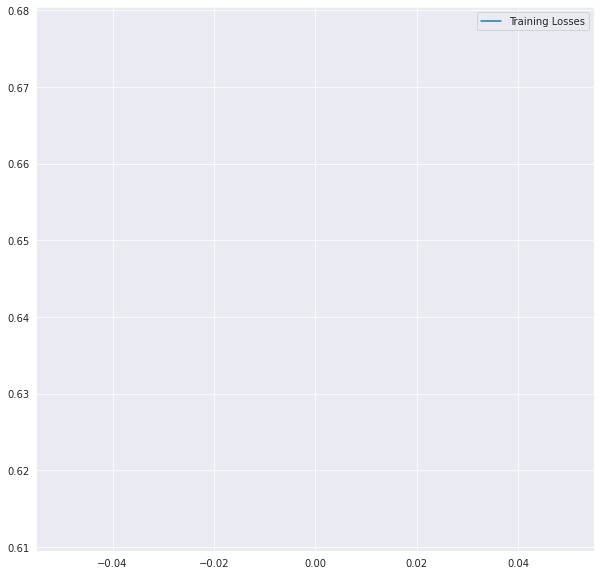

1
5 0.6261914968490601
10 0.4708934426307678
15 0.7118939757347107
20 0.4322759509086609
25 0.5461581945419312
30 0.4599131643772125
35 0.6700762510299683
40 0.6634774208068848
45 0.5414646863937378
50 0.5628426671028137
55 0.48155367374420166
60 0.6987922191619873
65 0.7202301621437073
70 0.4754948019981384
75 0.6025671362876892


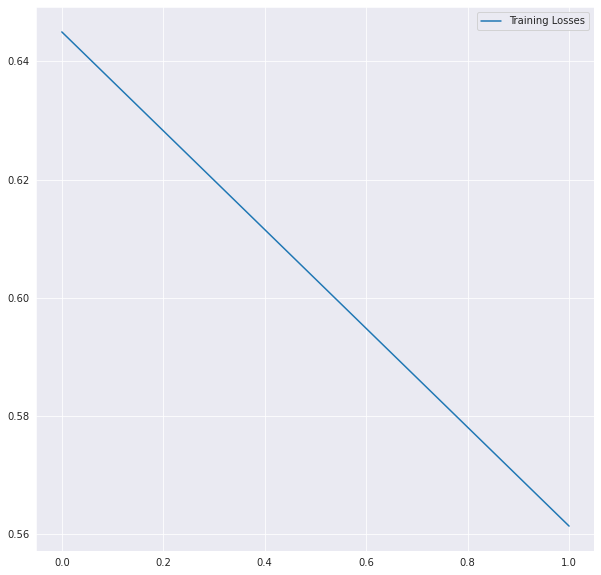

2
5 0.5326128602027893
10 0.5795338749885559
15 0.5133239030838013
20 0.36263307929039
25 0.6252335906028748
30 0.5277609825134277
35 0.46318352222442627
40 0.5825585126876831
45 0.4912274479866028
50 0.4620758295059204
55 0.7189861536026001
60 0.42415016889572144
65 0.47414472699165344
70 0.5951123237609863
75 0.4907791316509247


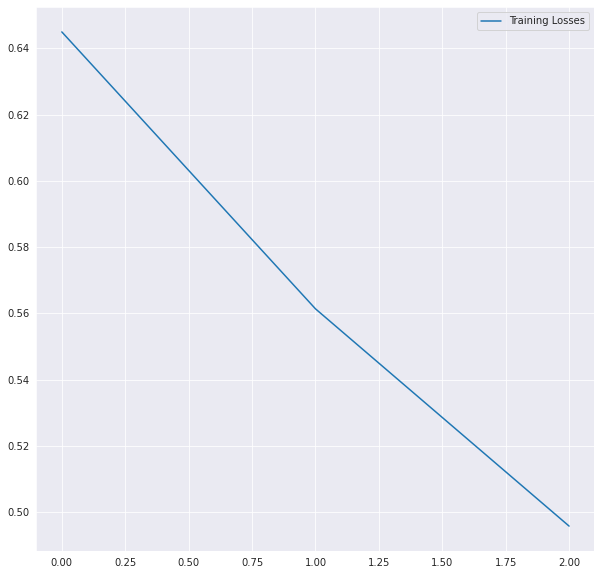

3
5 0.561701774597168
10 0.6616283655166626
15 0.5272490382194519
20 0.4996010661125183
25 0.412295401096344
30 0.560877799987793
35 0.4532001316547394
40 0.3838077485561371
45 0.32799699902534485
50 0.3726695775985718
55 0.45712319016456604
60 0.32356521487236023
65 0.5036001205444336
70 0.3081474304199219
75 0.5193174481391907


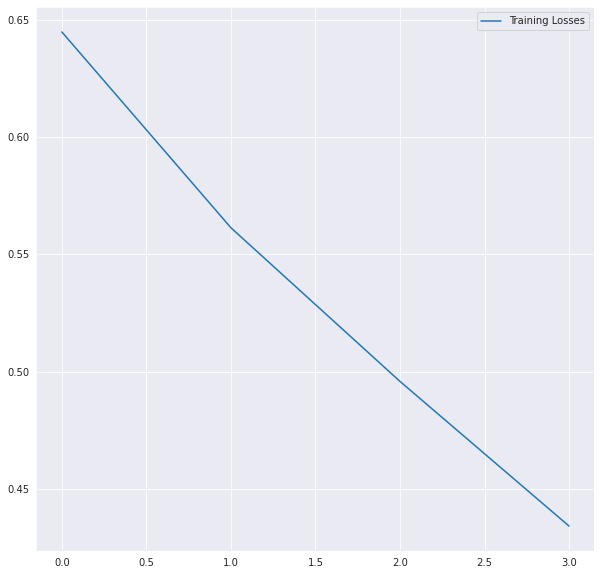

4
5 0.32219117879867554
10 0.3117765188217163
15 0.4390227496623993
20 0.40561792254447937
25 0.3370569050312042
30 0.3335161507129669
35 0.3726092576980591
40 0.46638137102127075
45 0.5369277596473694
50 0.3379511833190918
55 0.38447457551956177
60 0.4572334587574005
65 0.49704432487487793
70 0.3836948871612549
75 0.5583853125572205


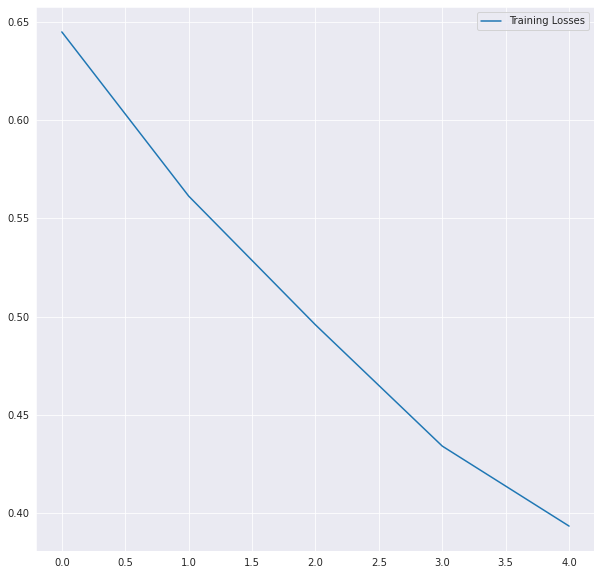

5
5 0.3119814097881317
10 0.355825811624527
15 0.34409576654434204
20 0.25507766008377075
25 0.2181304544210434
30 0.2574411630630493
35 0.32864445447921753
40 0.3729919195175171
45 0.2542957365512848
50 0.3452152609825134
55 0.3635067939758301
60 0.35152697563171387
65 0.2620442509651184
70 0.35177597403526306
75 0.405996173620224


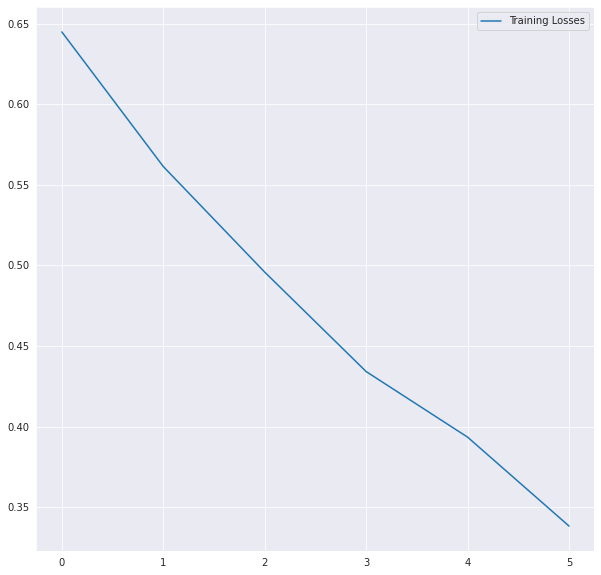

6


KeyboardInterrupt: ignored

In [ ]:
import torch.optim as optim
losses_train = []
num_epochs = 10

# using SGD optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


TRAINING = True

  
def get_mean_of_list(L):
    return sum(L) / len(L)

if TRAINING:
   

    # run a for loop for num_epochs
    for epoch in range(num_epochs):

        # a list to store losses for each epoch
        epoch_losses_train = []
        counter1= 0
        # run a for loop for each batch
        print(epoch)
        for (_, sample_batched) in enumerate(dataloader_training_dataset_mutated):
            
            # zero out grads
            optimizer.zero_grad()

            # retrieve x1 and x2 the two song batches
            x1 = sample_batched['song1']
            x2 = sample_batched['song2']

            #stacking
            x1 = stacker(x1)
            x2 = stacker(x2)

            # move them to the device
            x1 = x1.to(device,dtype=torch.float)
            x2 = x2.to(device,dtype=torch.float)

            # get their outputs


            y1 = model(x1)
            y2 =model(x2)

            # get loss value
            loss = loss_function(y1, y2)
            
            # put that loss value in the epoch losses list
            epoch_losses_train.append(loss.cpu().data.item())

            # perform backprop on loss value to get gradient values
            loss.backward()

            # run the optimizer
            optimizer.step()
            counter1+=1
            if(counter1%5==0):
              print(counter1,loss.cpu().data.item())
        # append mean of epoch losses to losses_train, essentially this will reflect mean batch loss
        losses_train.append(get_mean_of_list(epoch_losses_train))

        # Plot the training losses Graph and save it
        fig = plt.figure(figsize=(10, 10))
        sns.set_style('darkgrid')
        plt.plot(losses_train)
        plt.legend(['Training Losses'])
        plt.savefig('losses.png')        
        plt.close()

In [ ]:
PATH ="/content/gdrive/My Drive/music_class/third_model.pt "
torch.save(model.state_dict(), PATH)


torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5008333333333334


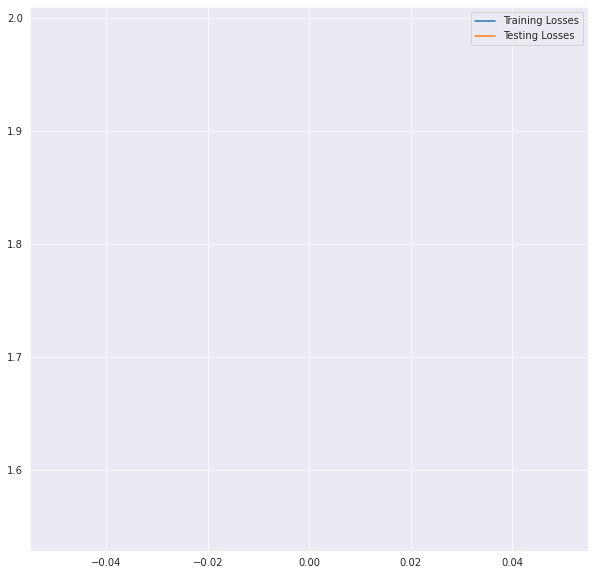

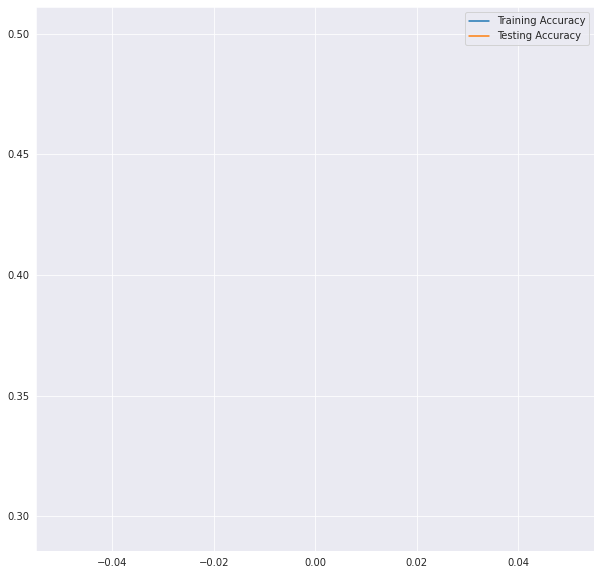

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.55


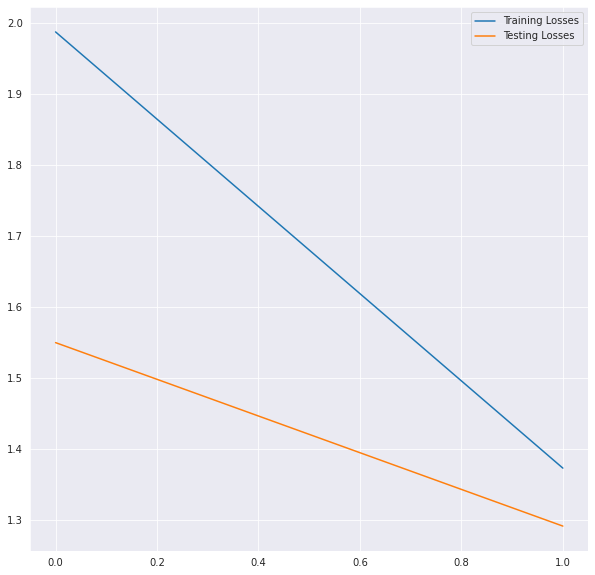

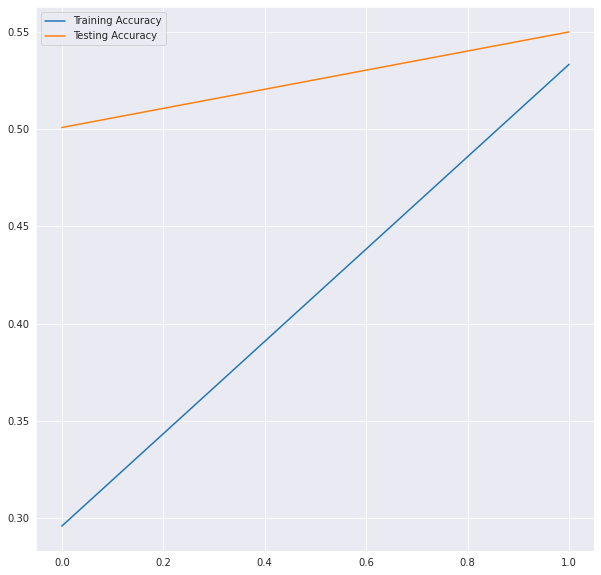

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5558333333333333


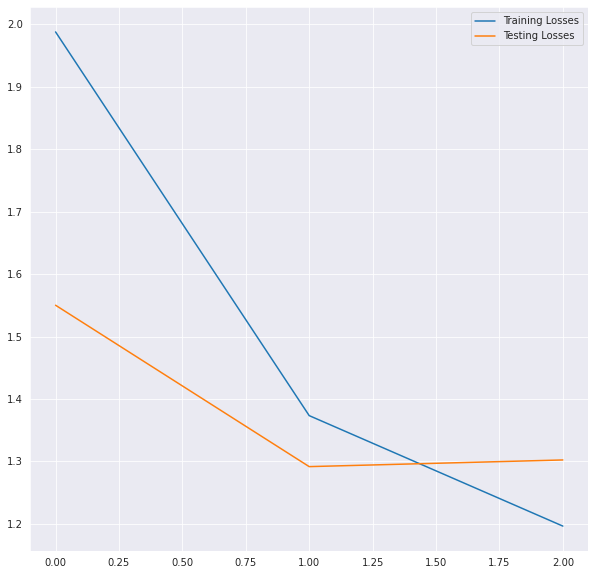

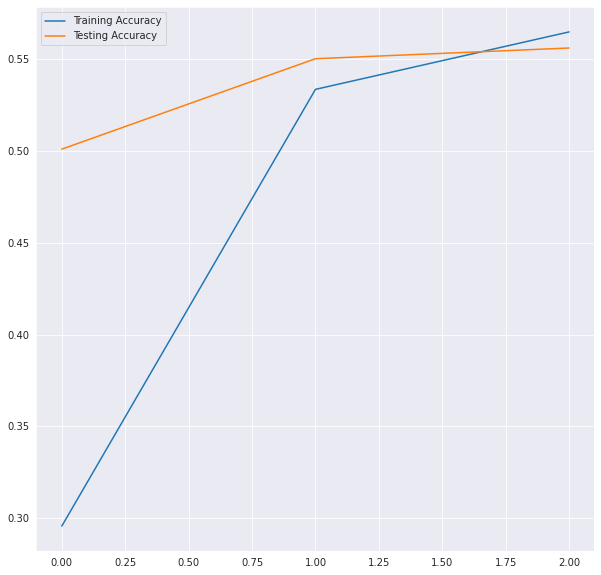

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.56


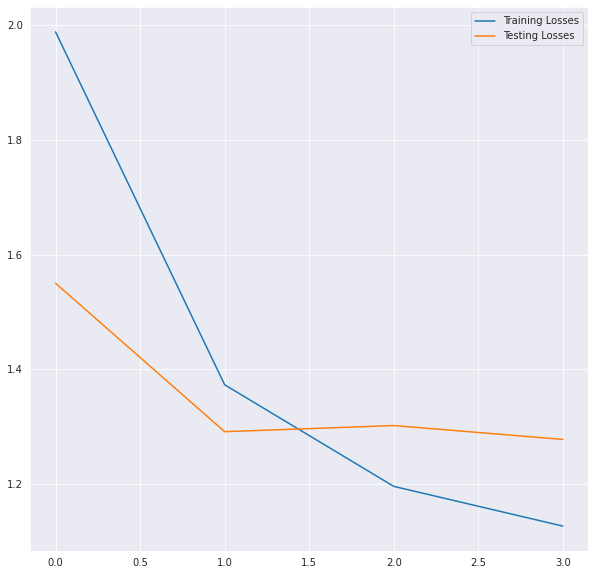

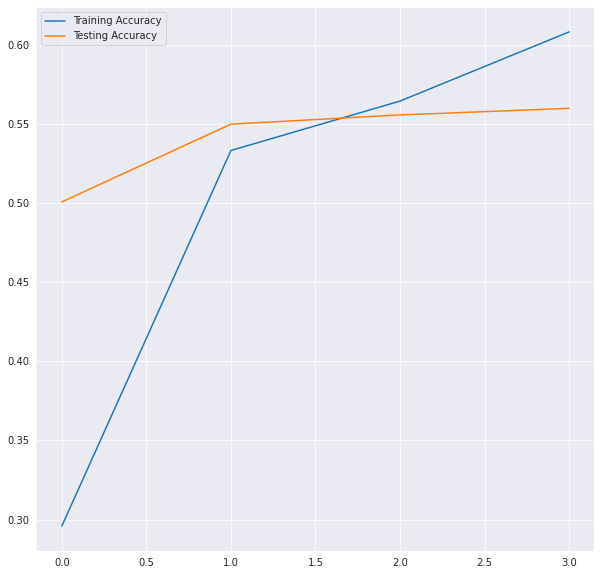

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5641666666666667


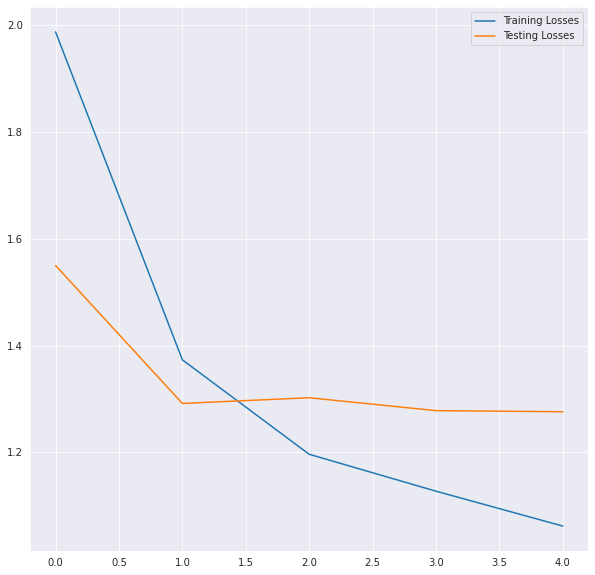

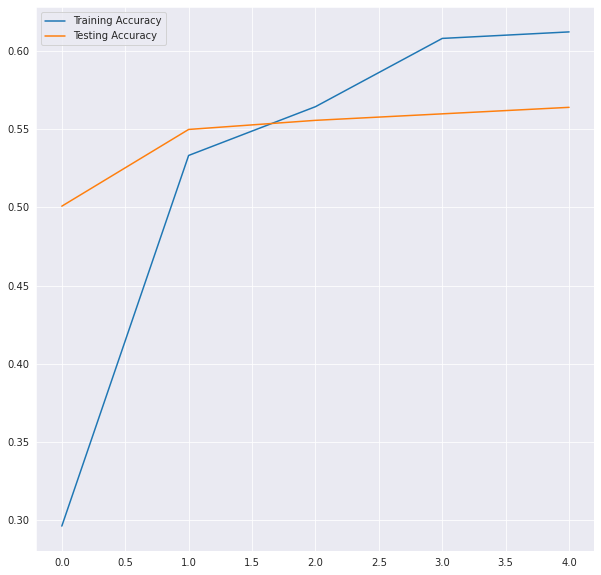

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5775


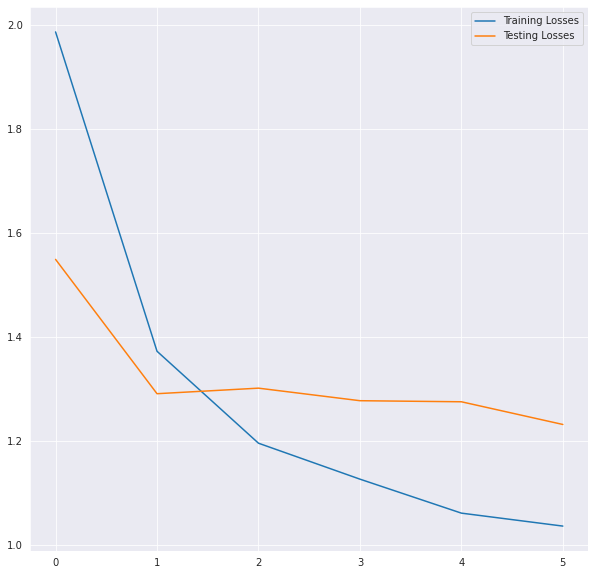

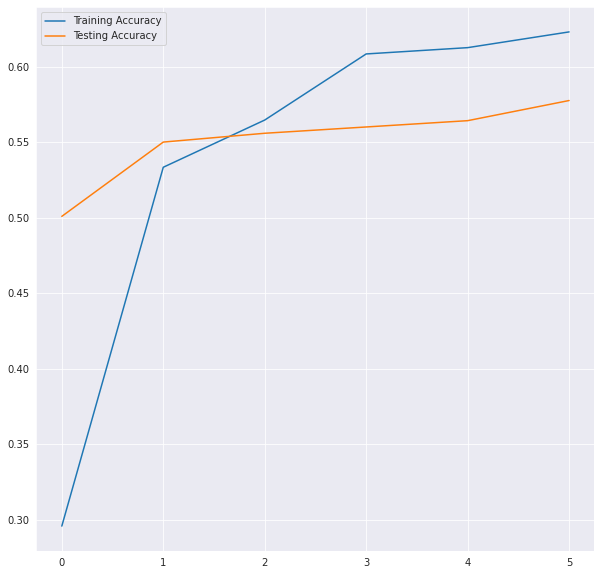

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5675


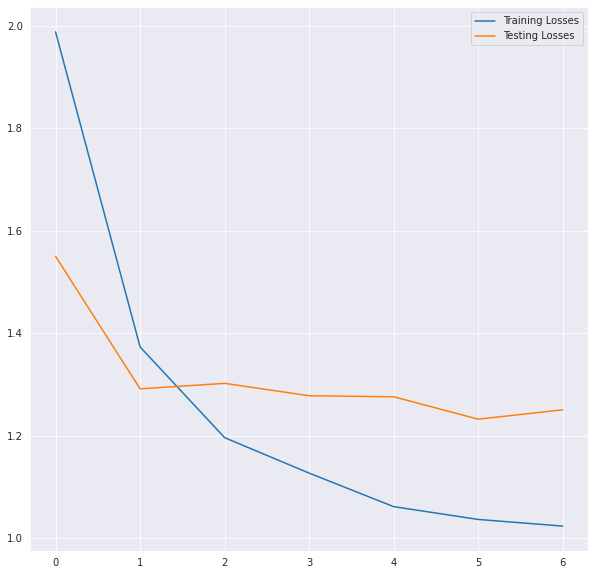

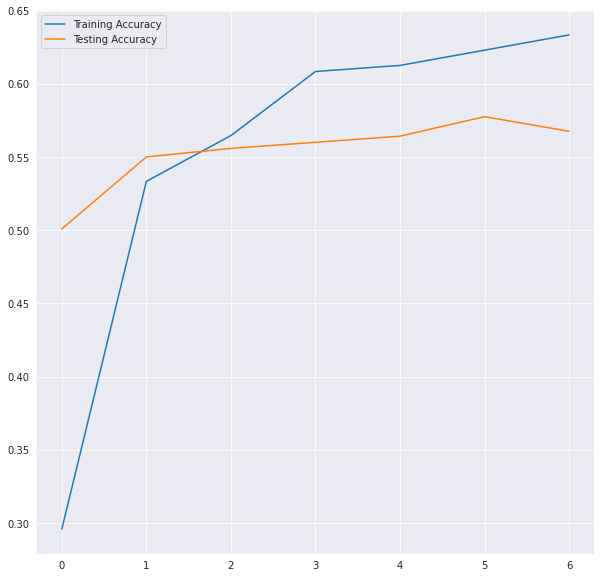

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5816666666666667


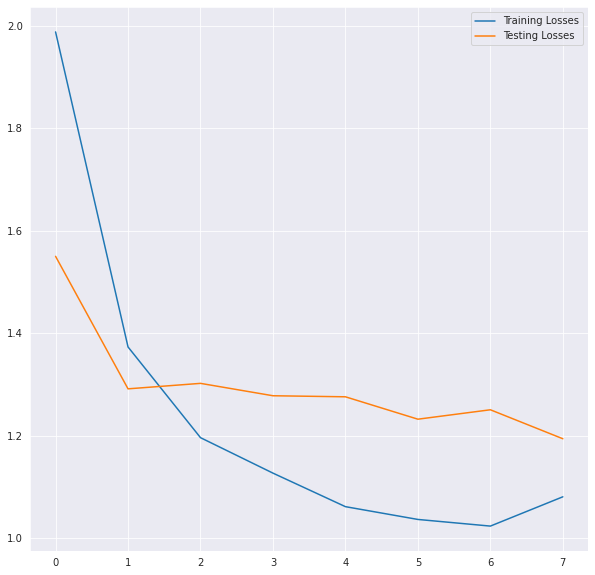

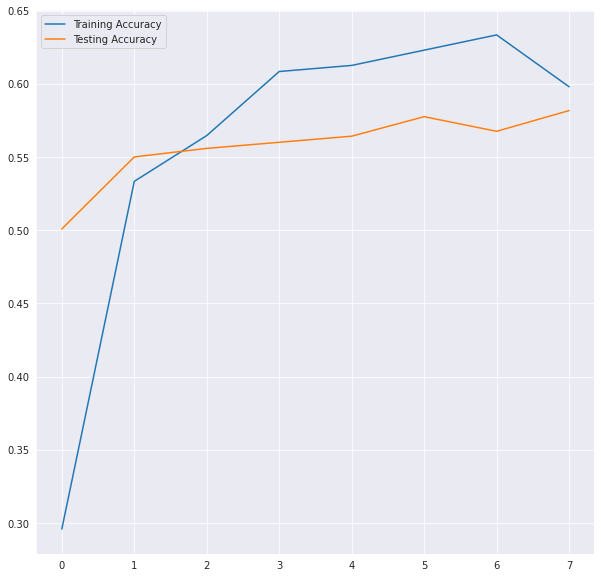

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.565


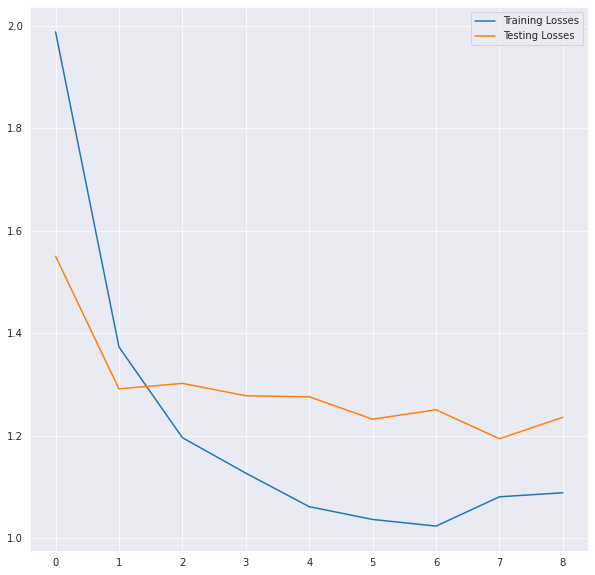

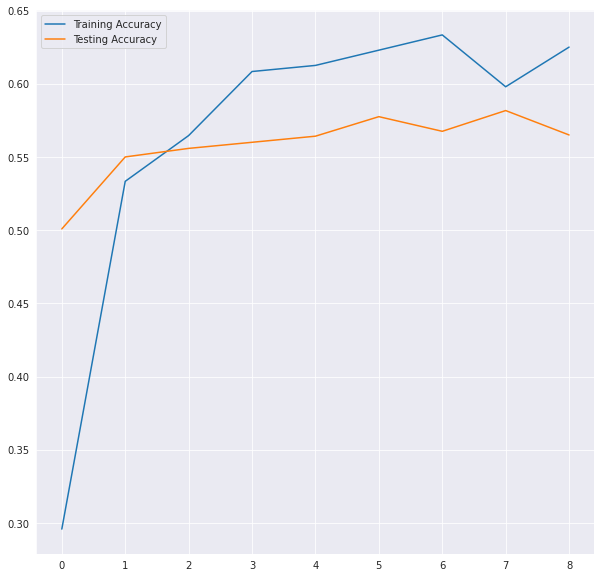

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5716666666666667


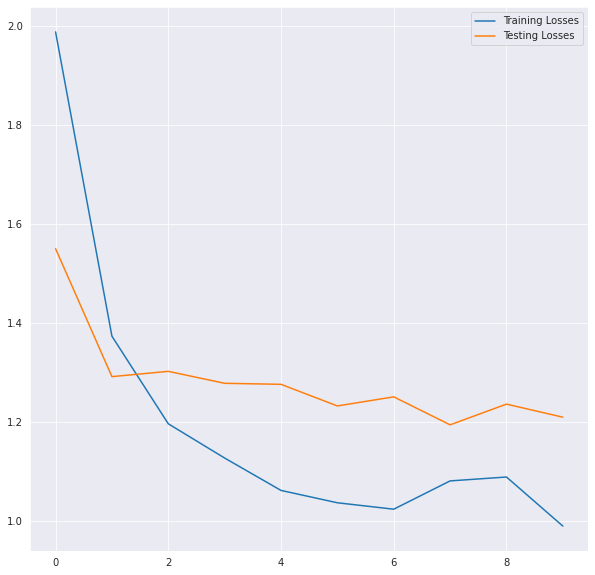

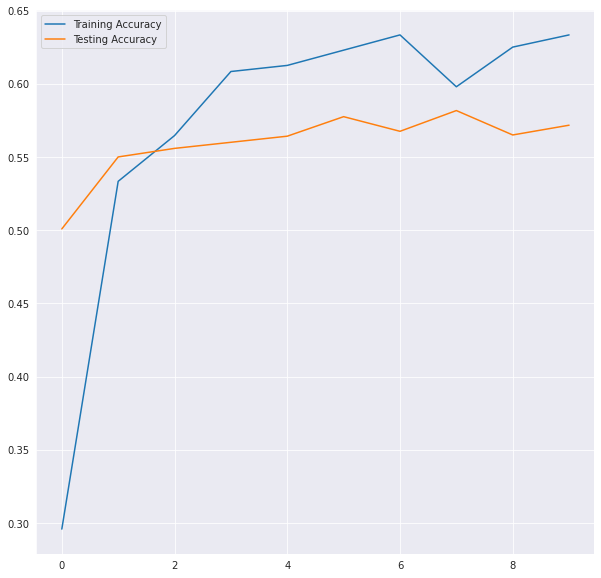

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5633333333333334


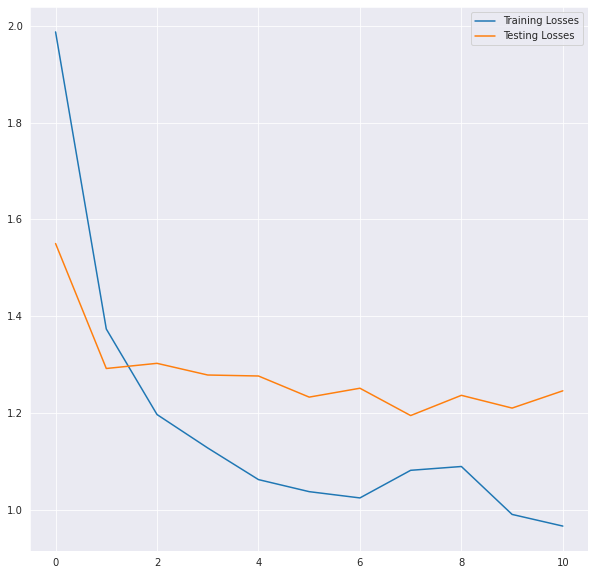

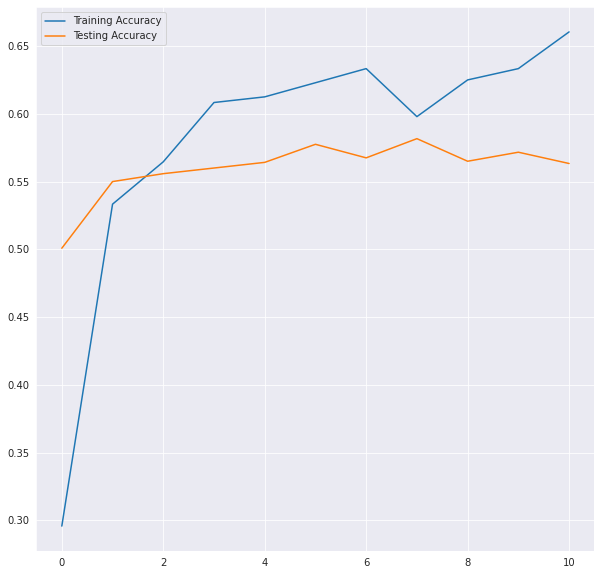

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.565


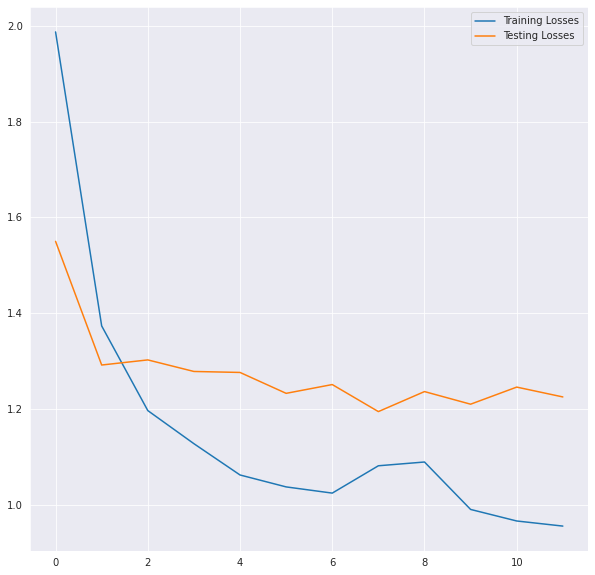

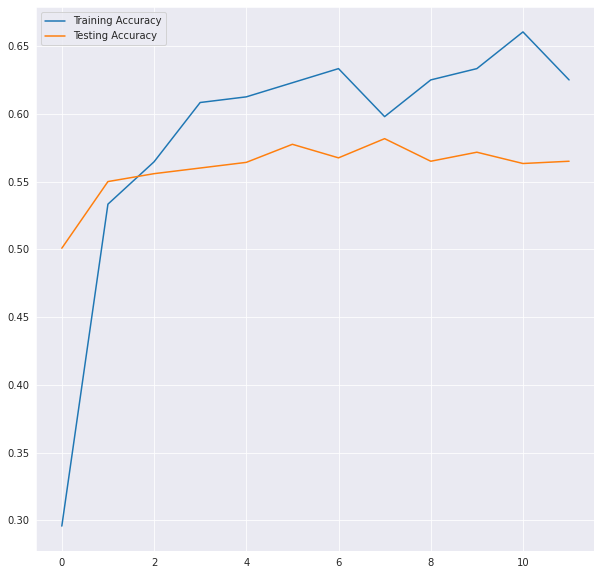

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.585


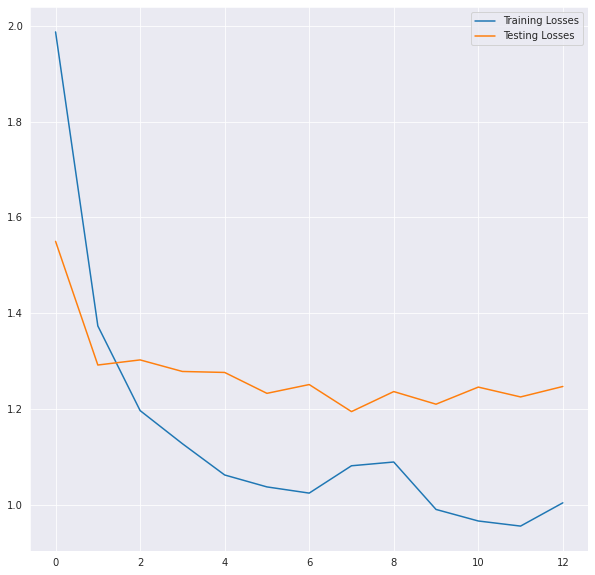

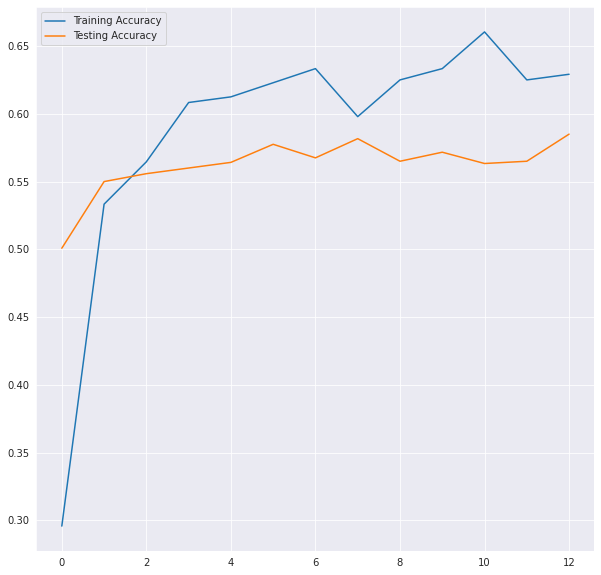

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5758333333333333


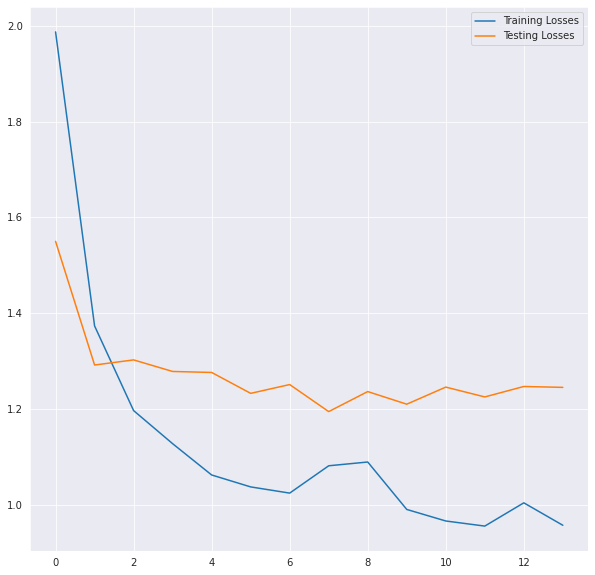

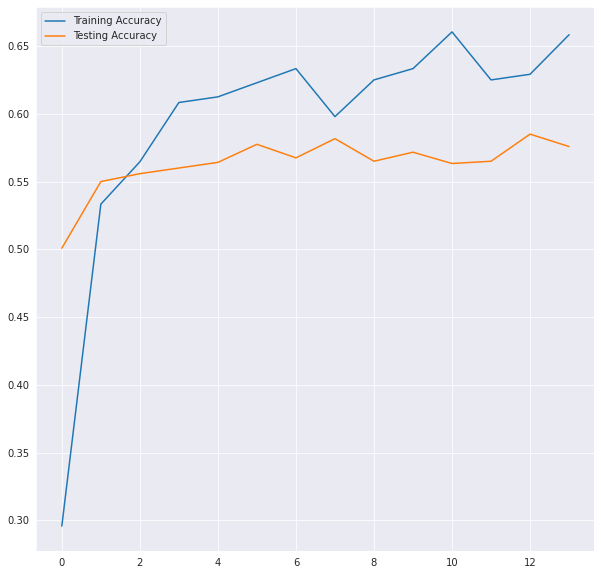

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.58


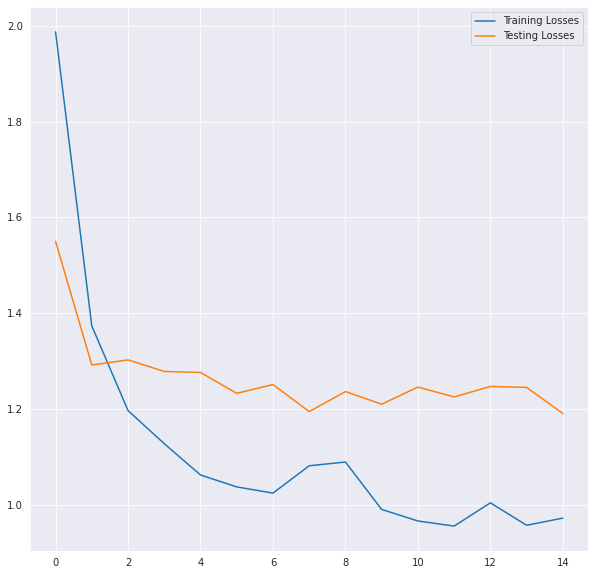

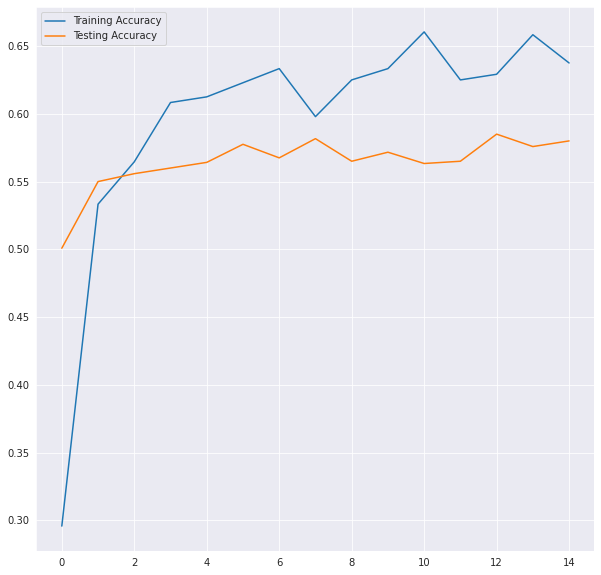

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5916666666666667


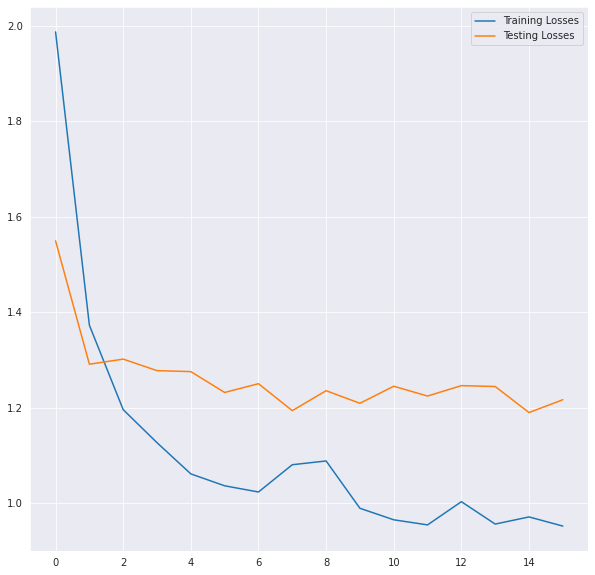

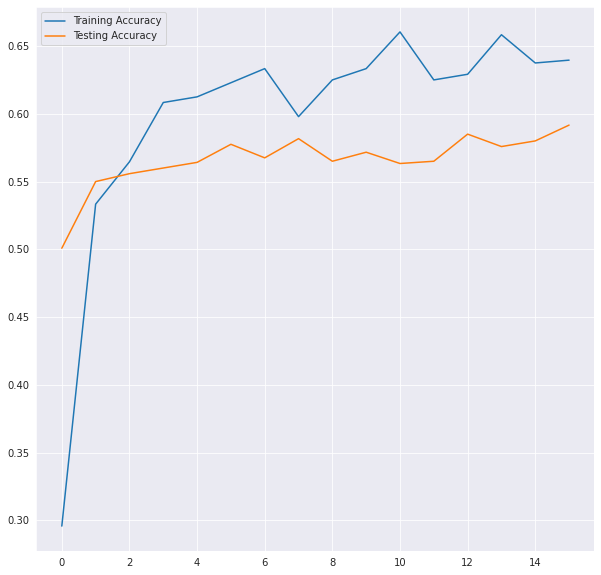

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5941666666666666


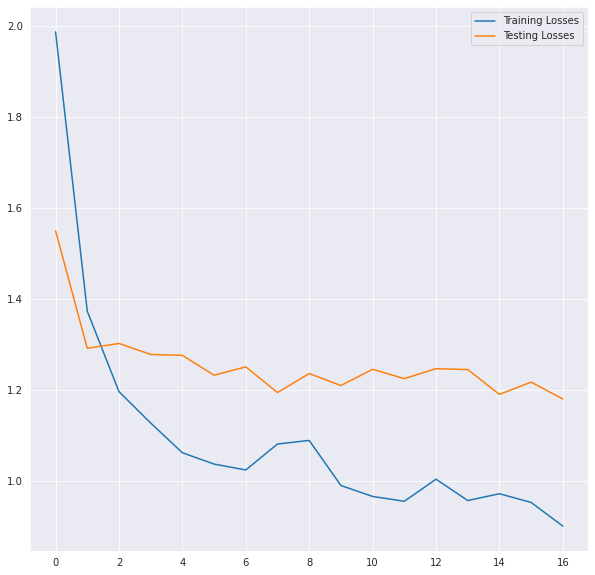

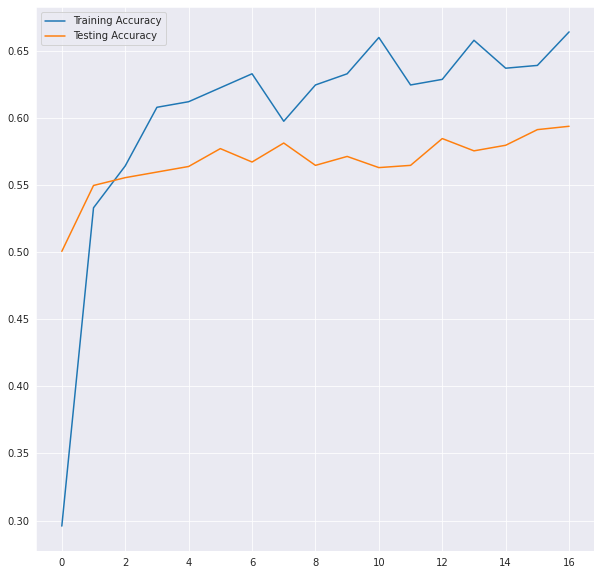

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5658333333333333


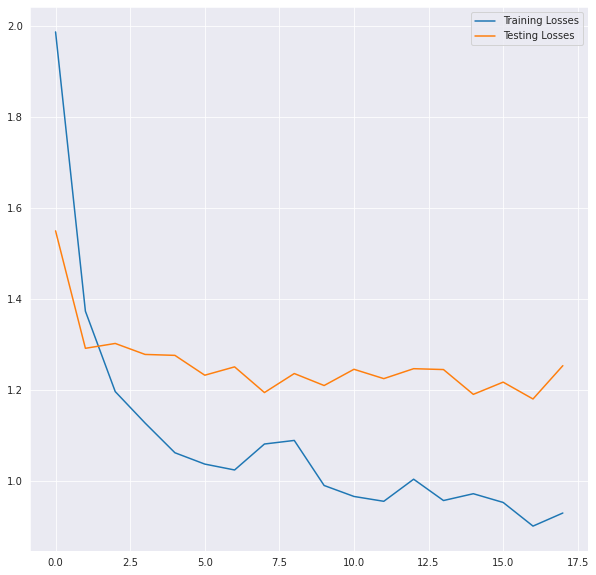

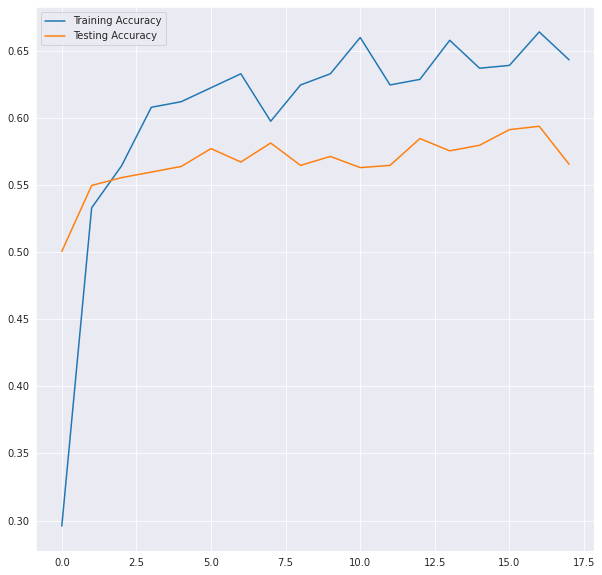

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5883333333333334


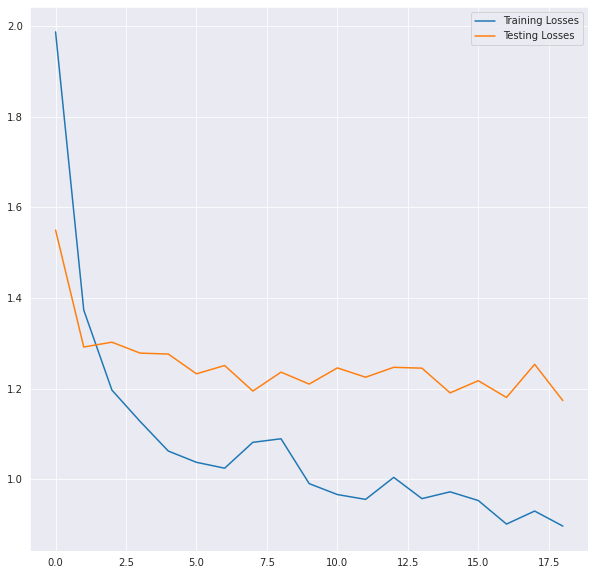

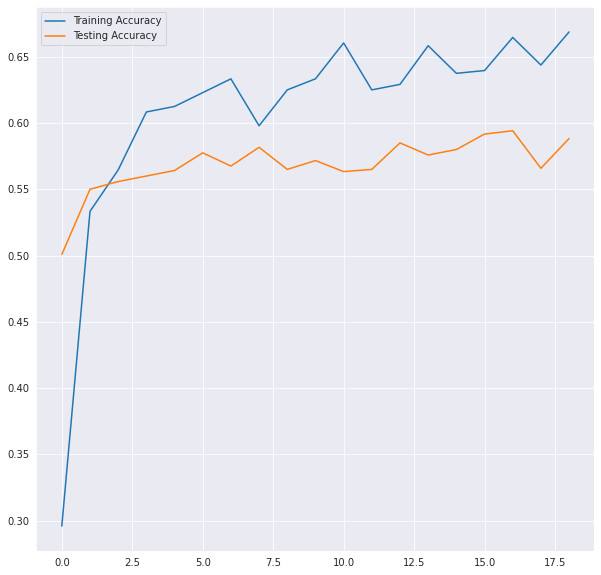

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5816666666666667


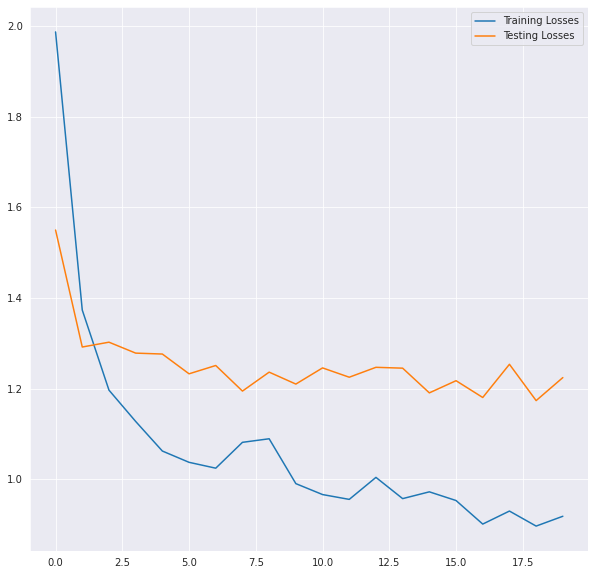

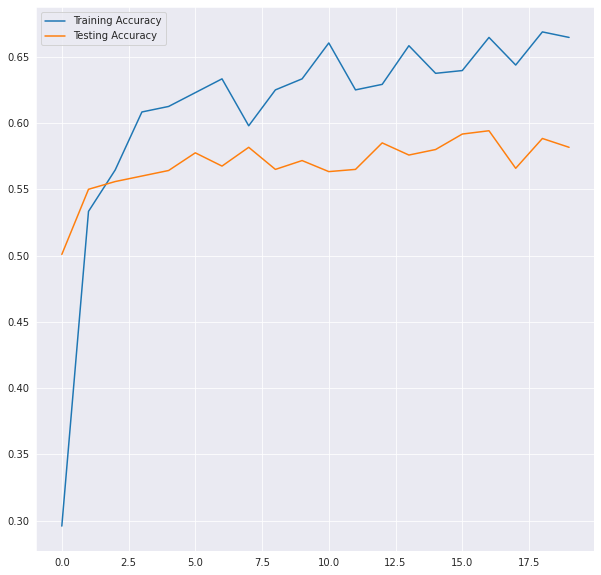

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5866666666666667


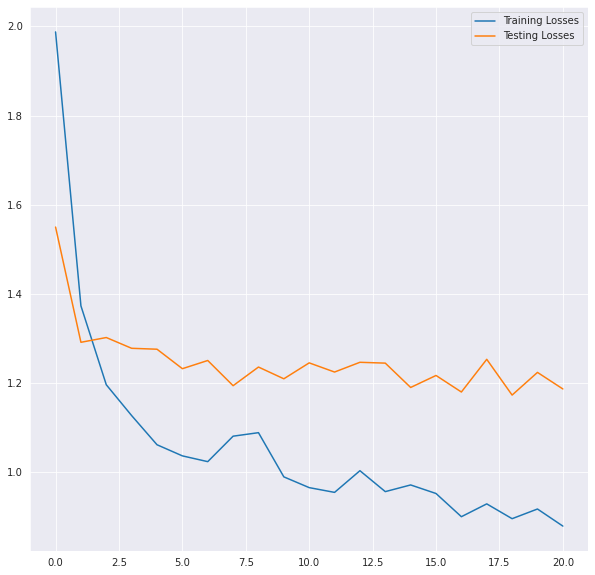

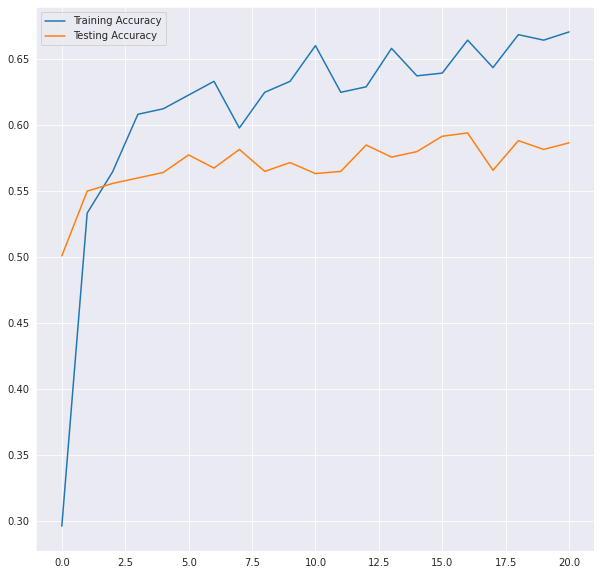

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.565


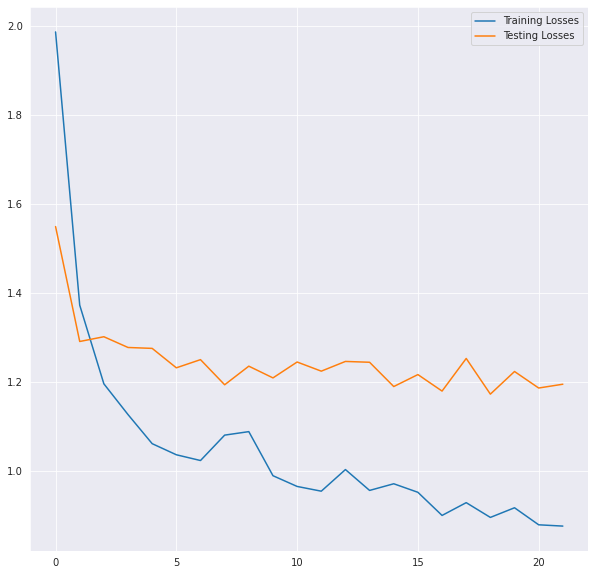

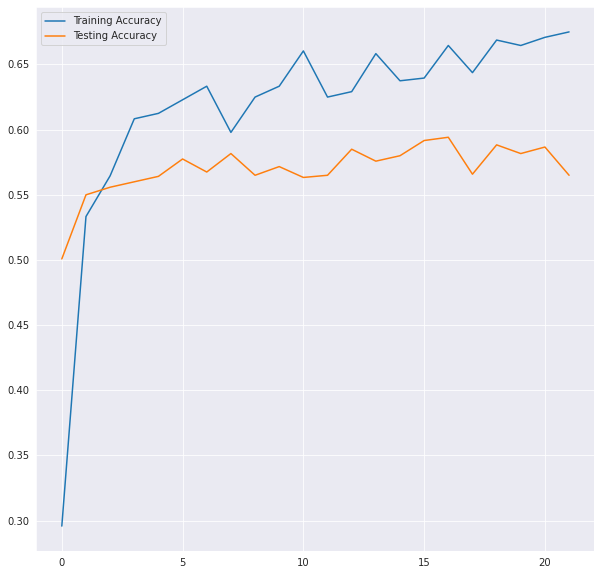

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5666666666666667


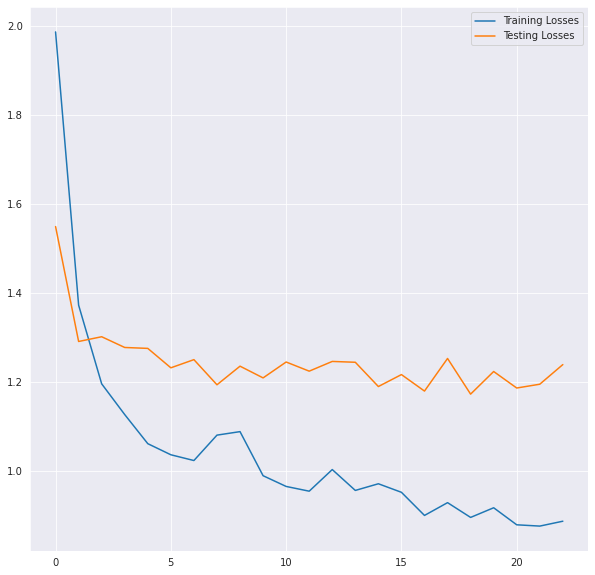

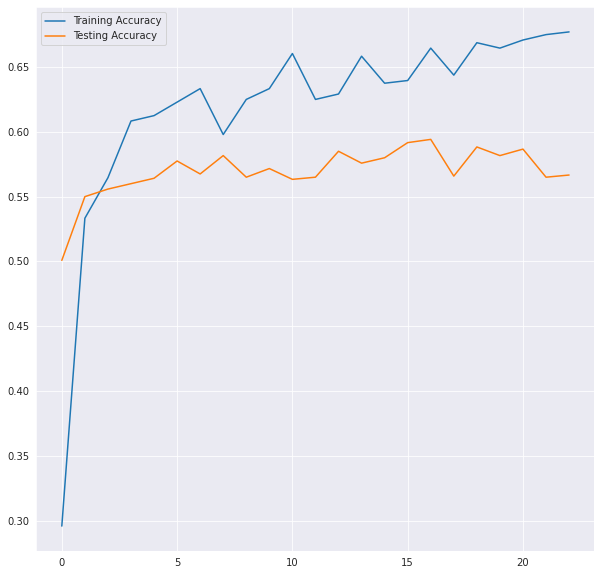

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5733333333333334


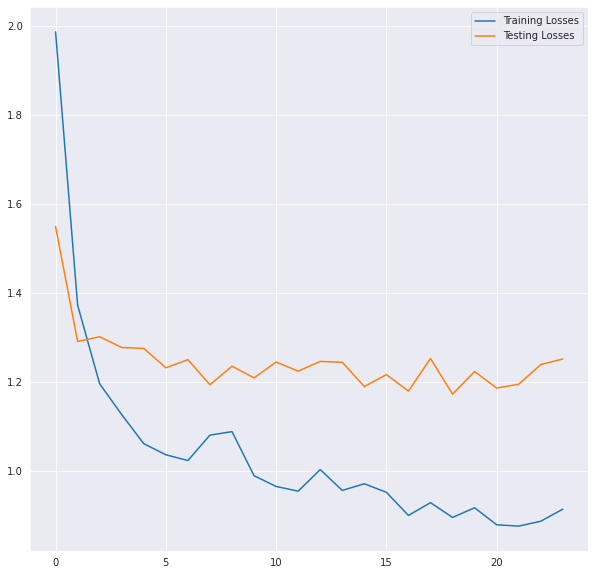

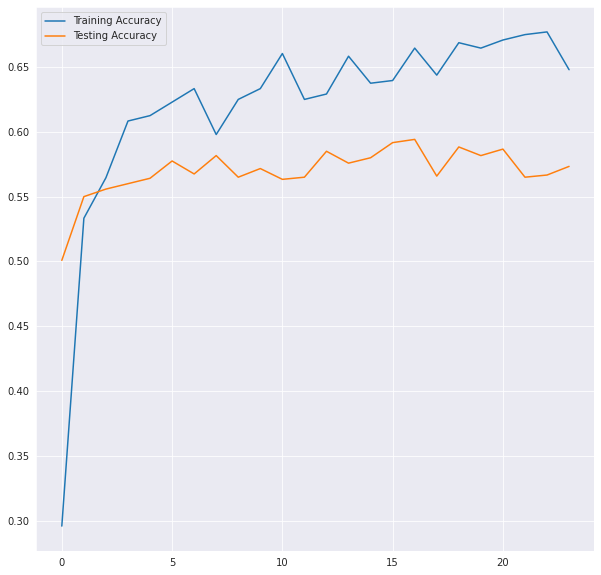

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5933333333333334


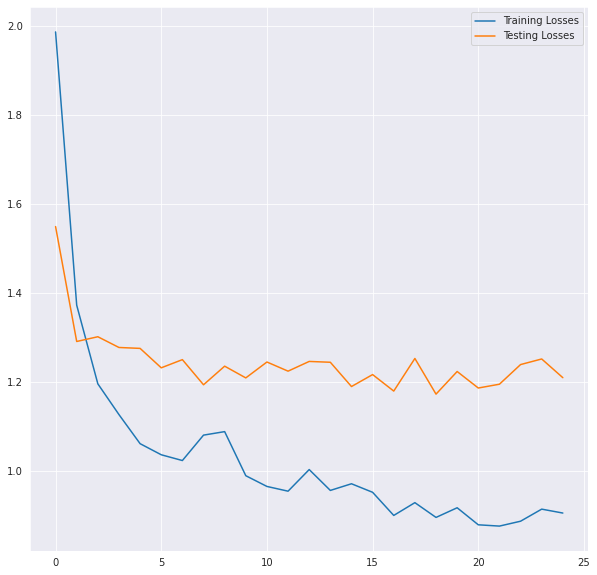

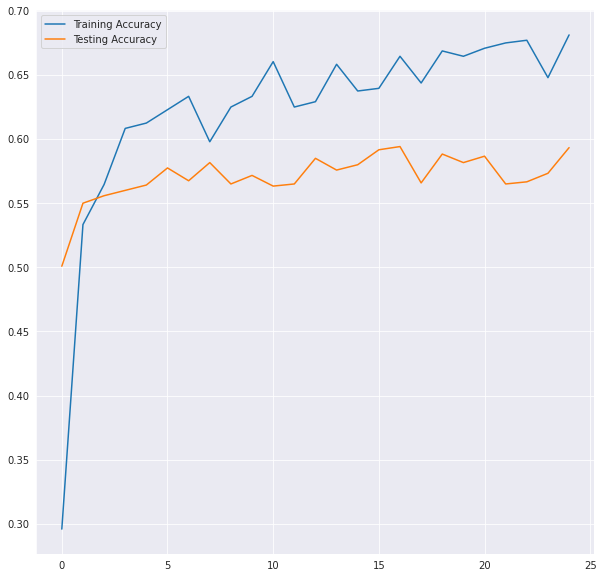

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5775


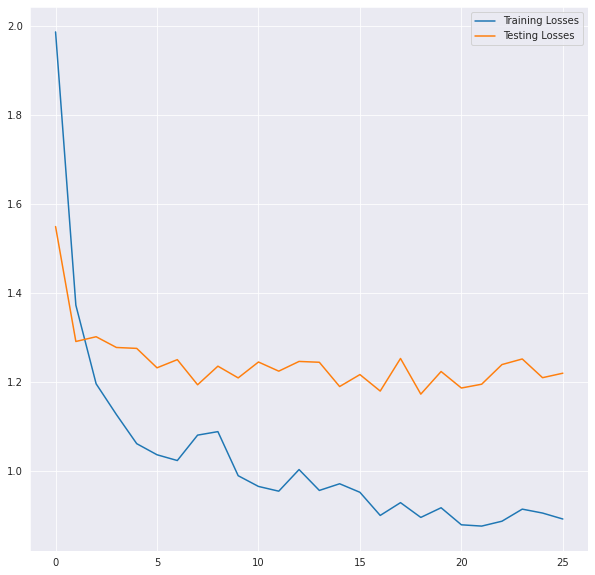

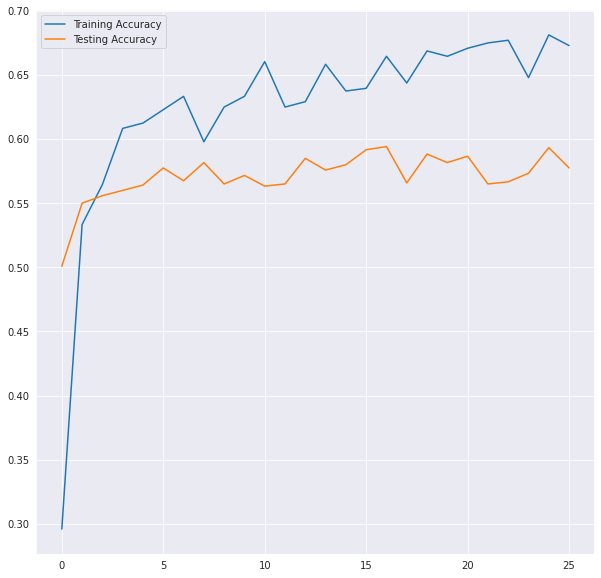

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5916666666666667


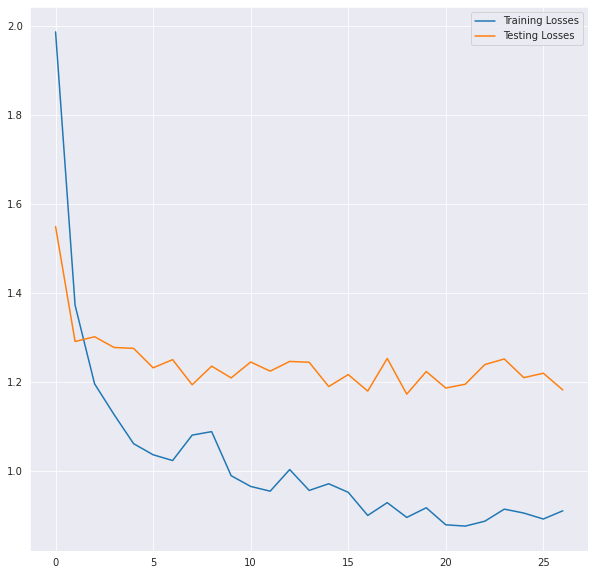

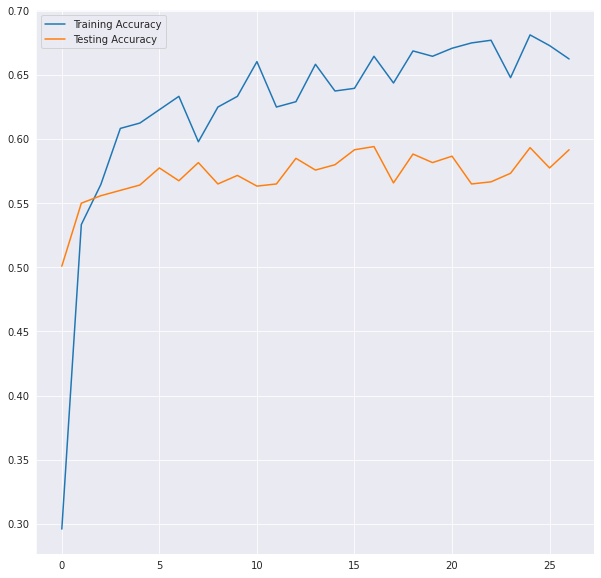

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5708333333333333


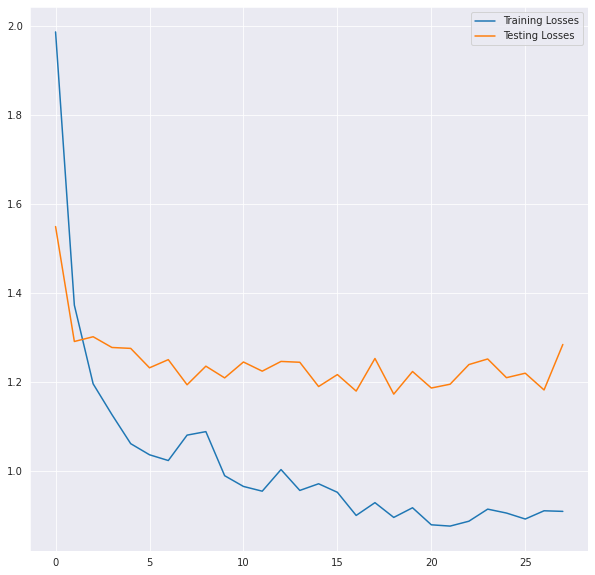

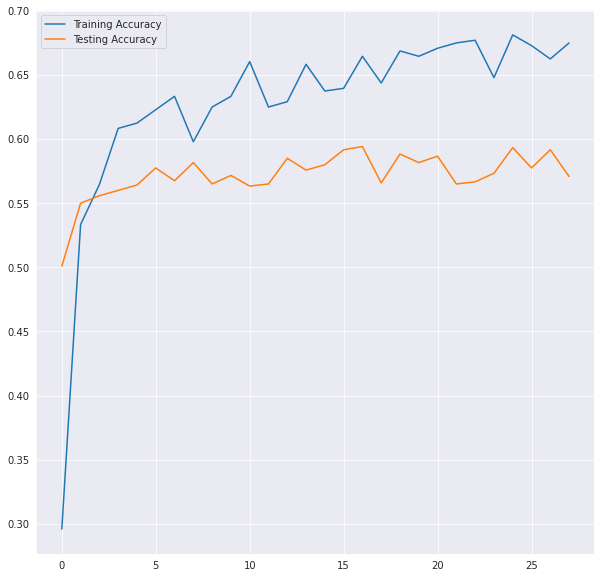

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5741666666666667


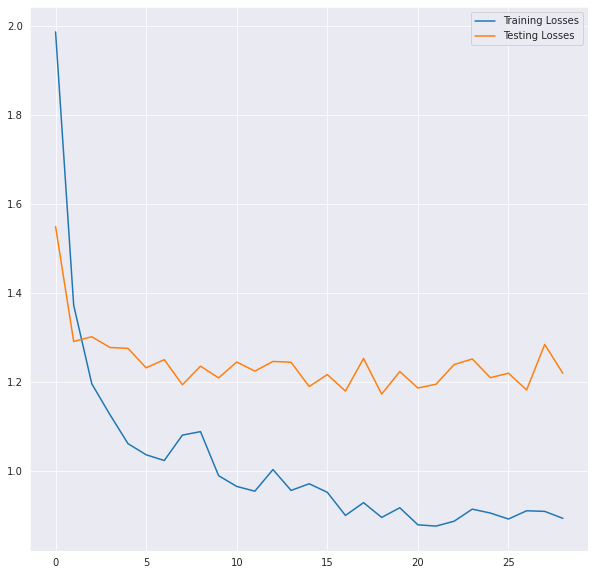

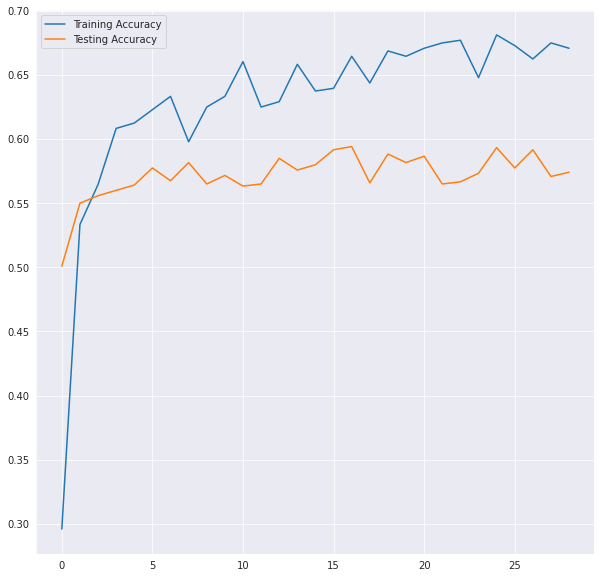

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5866666666666667


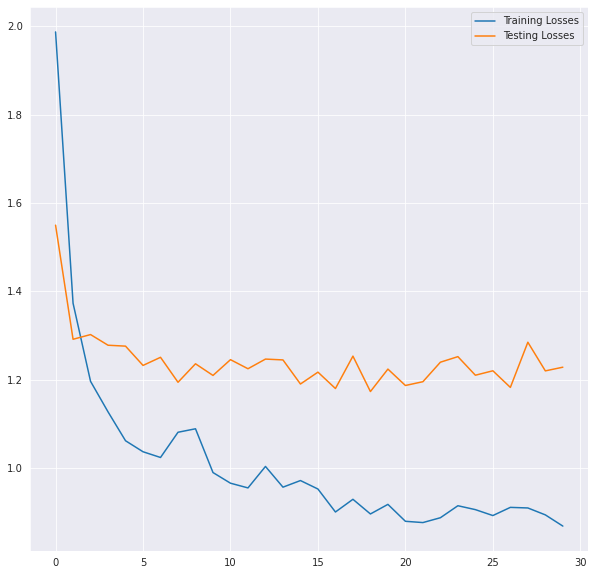

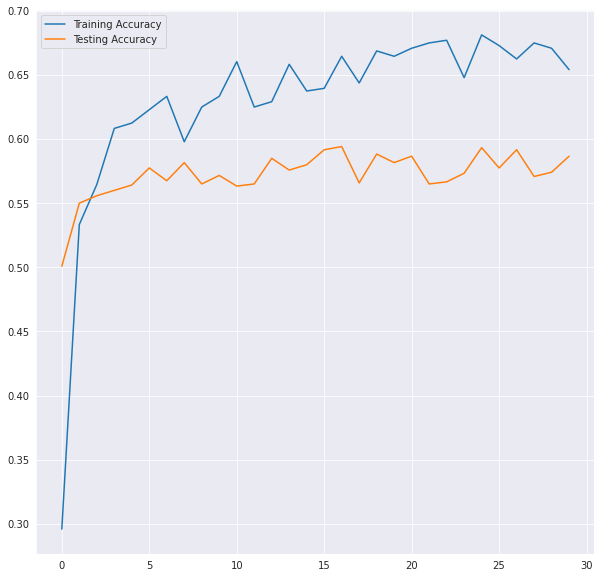

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5825


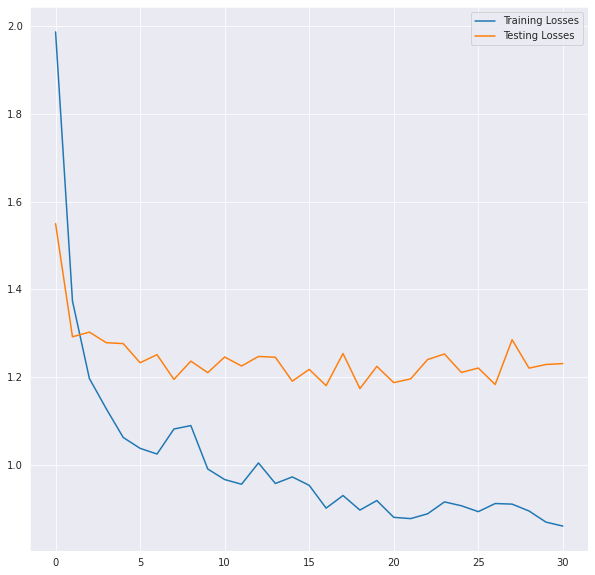

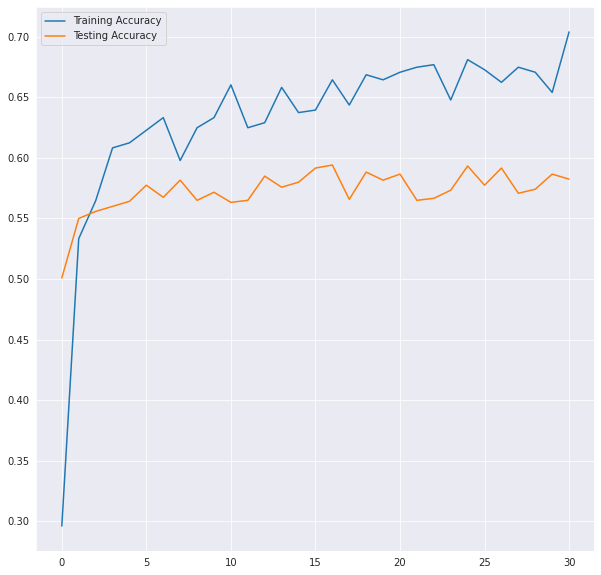

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.6008333333333333


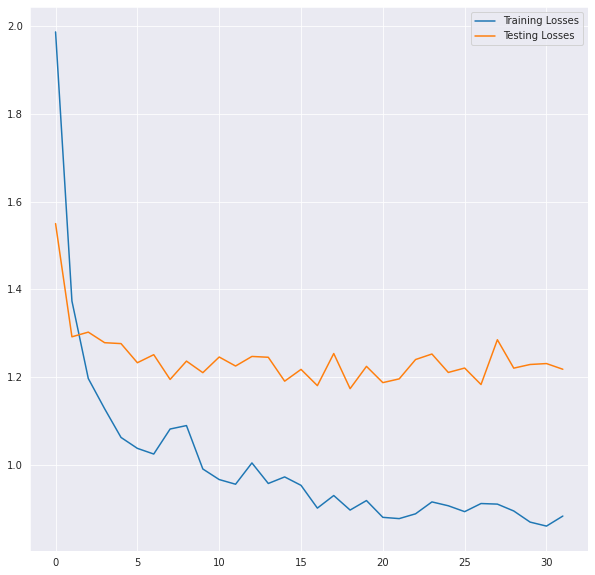

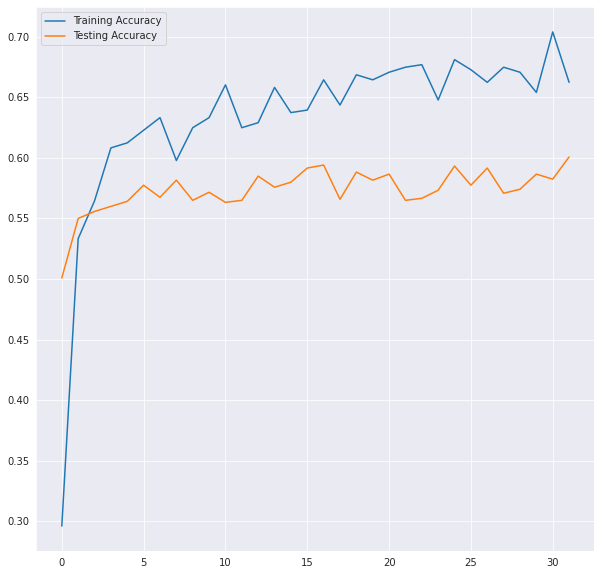

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5816666666666667


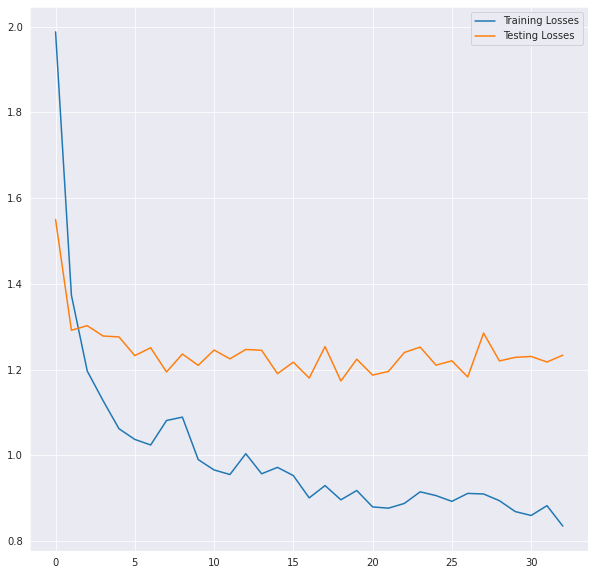

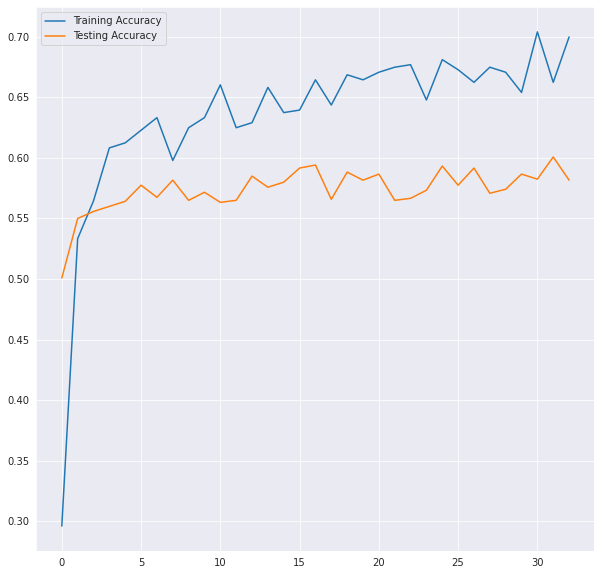

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5583333333333333


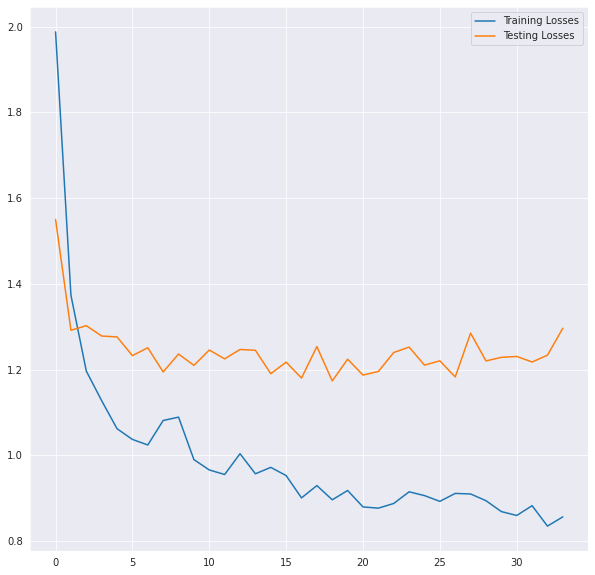

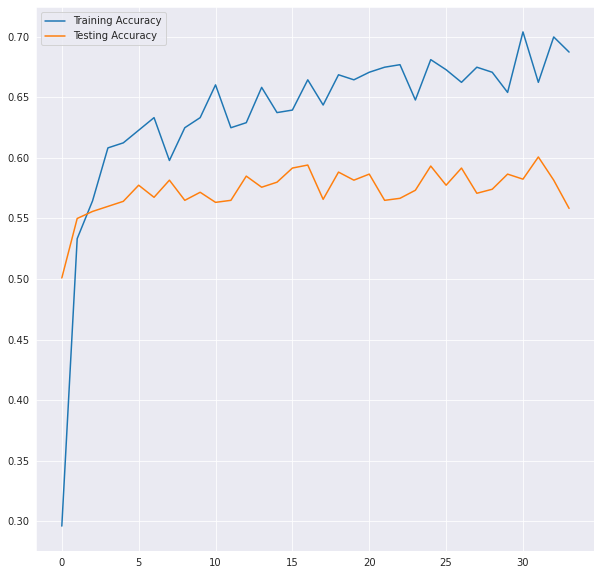

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.595


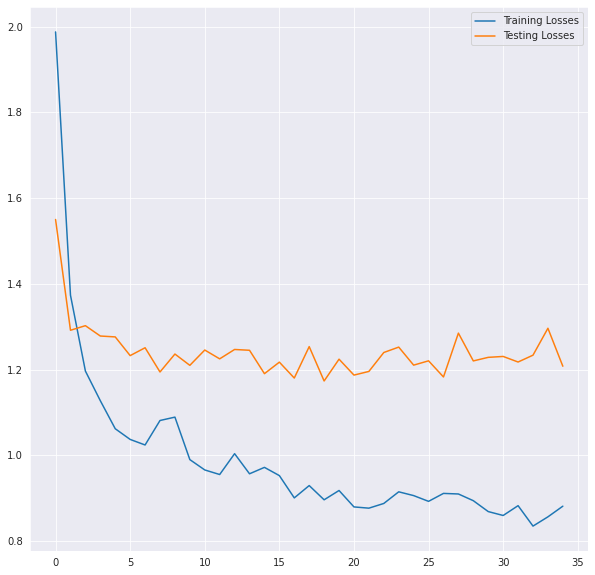

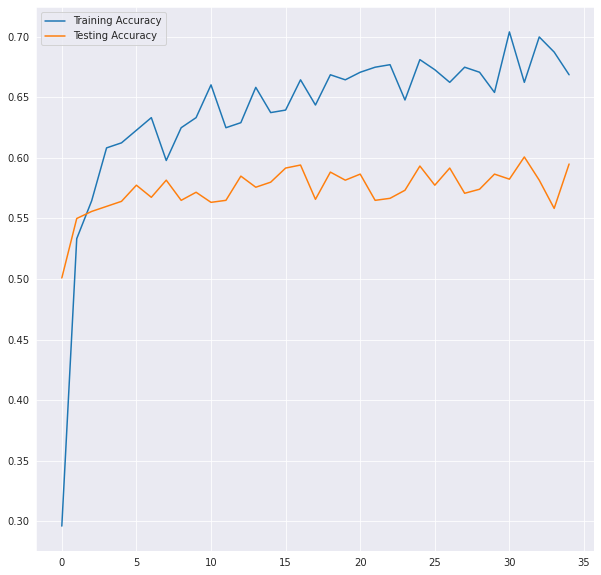

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5866666666666667


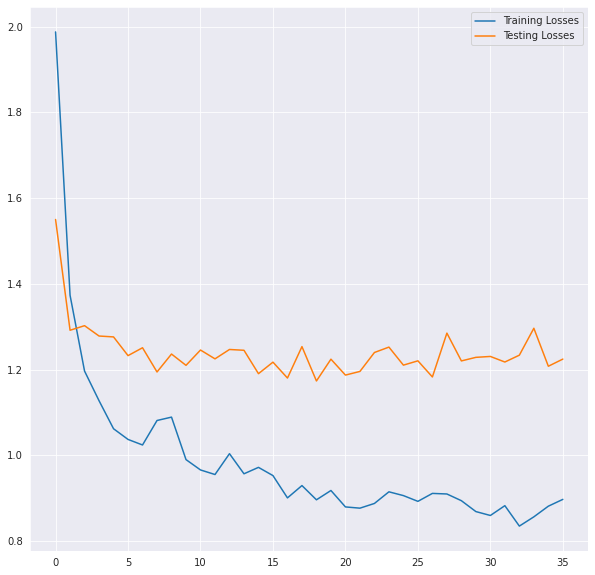

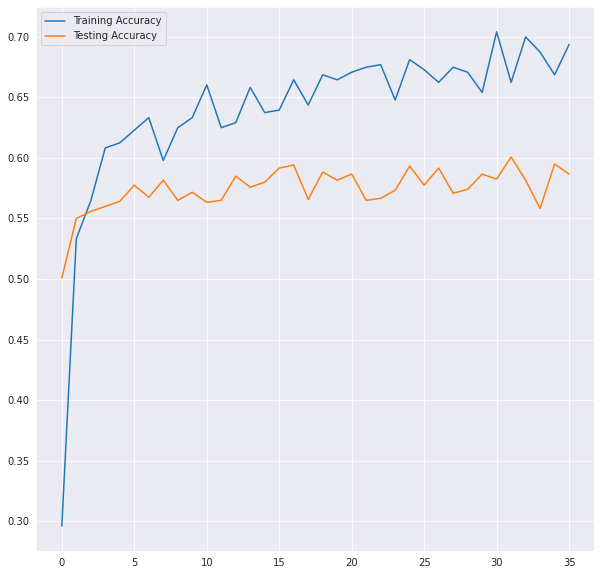

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5575


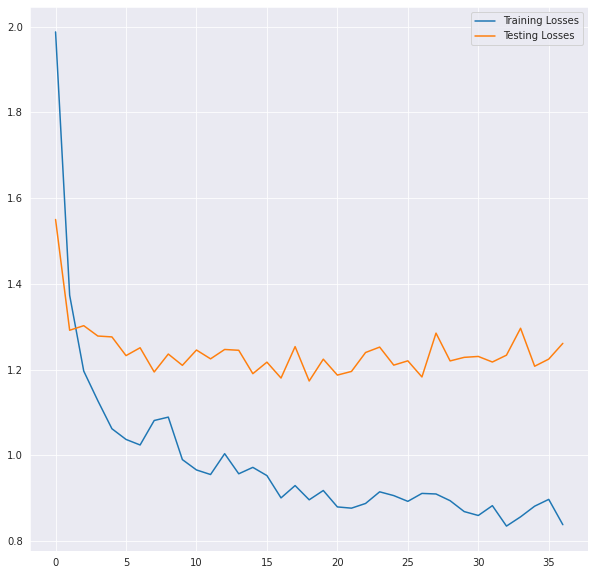

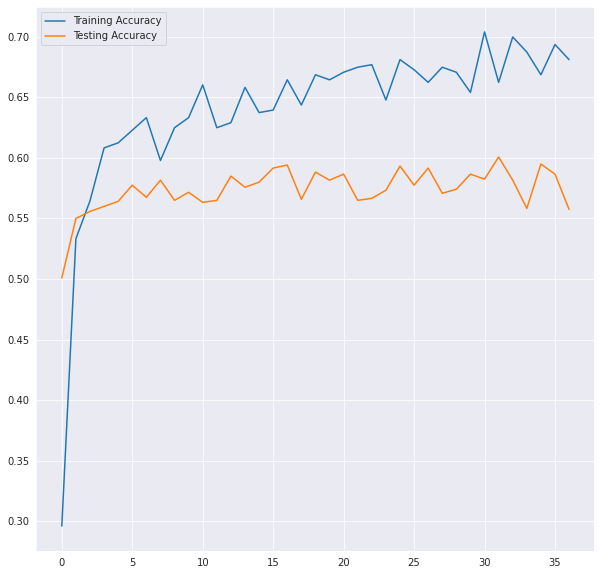

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5708333333333333


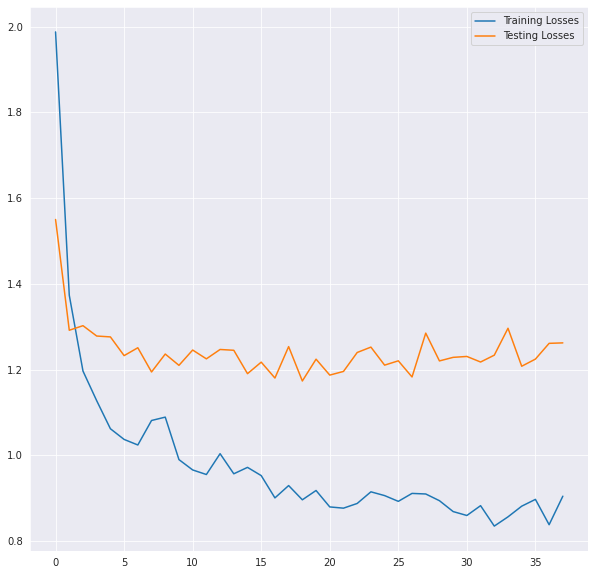

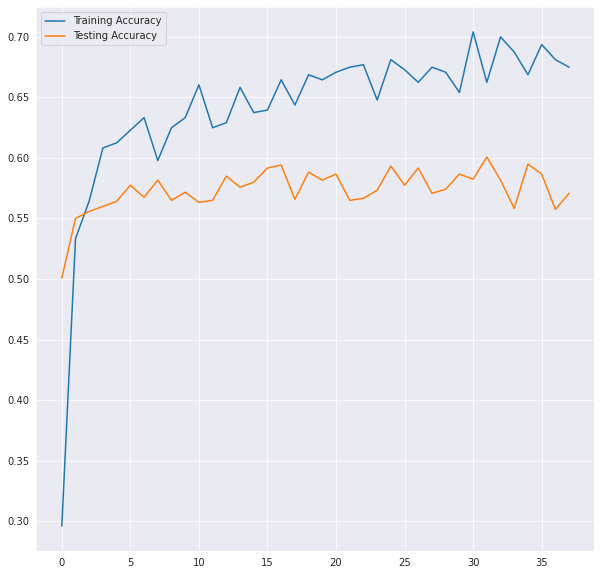

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.585


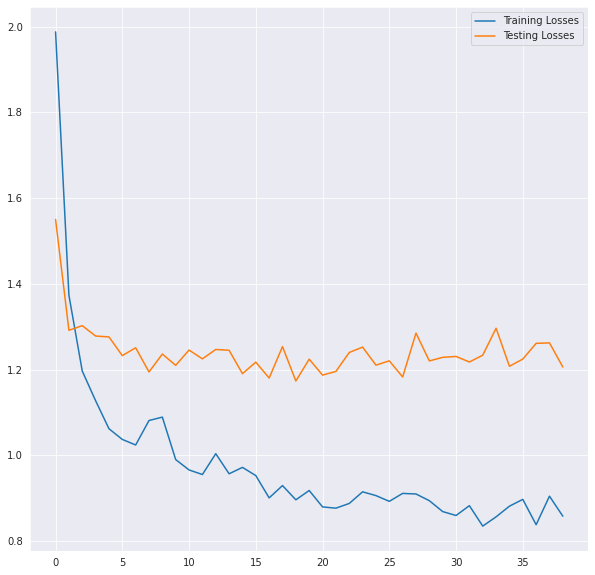

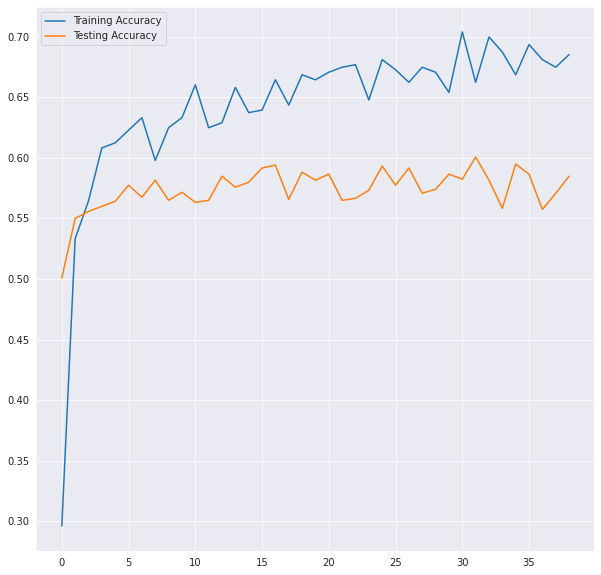

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5766666666666667


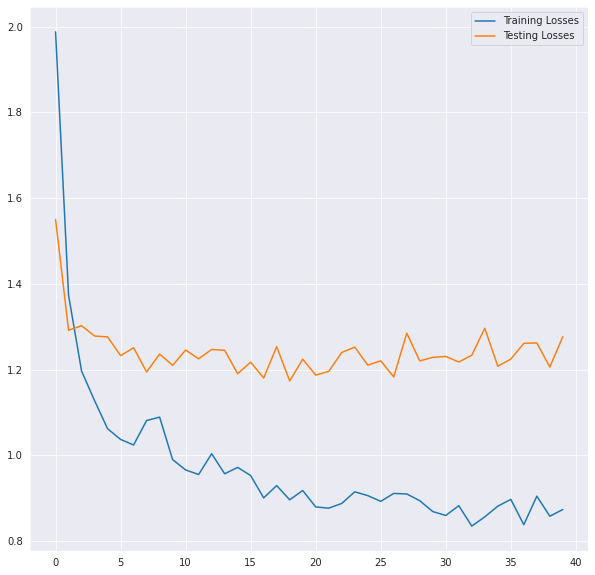

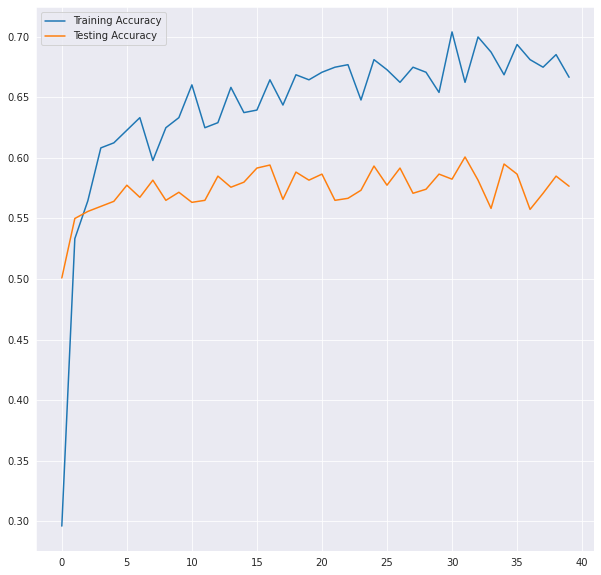

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5891666666666666


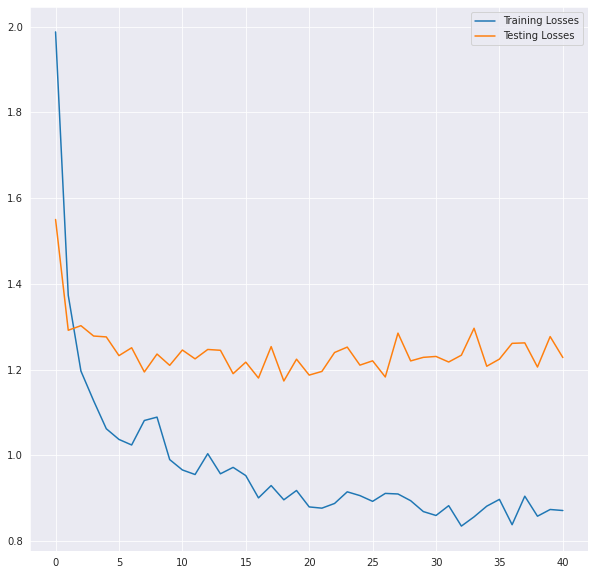

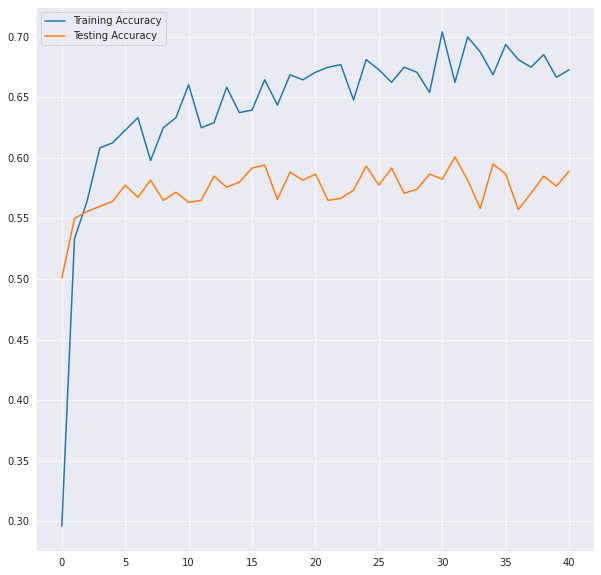

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5783333333333334


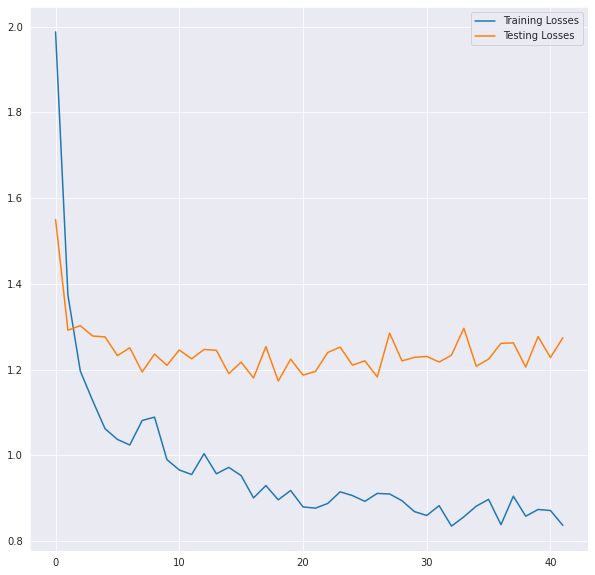

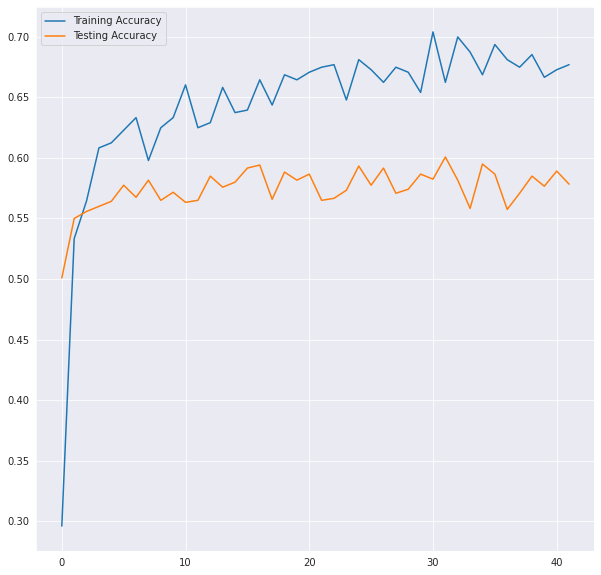

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.59


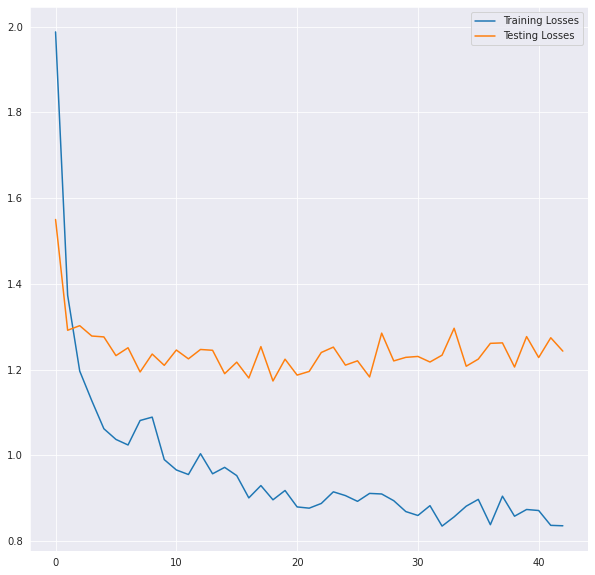

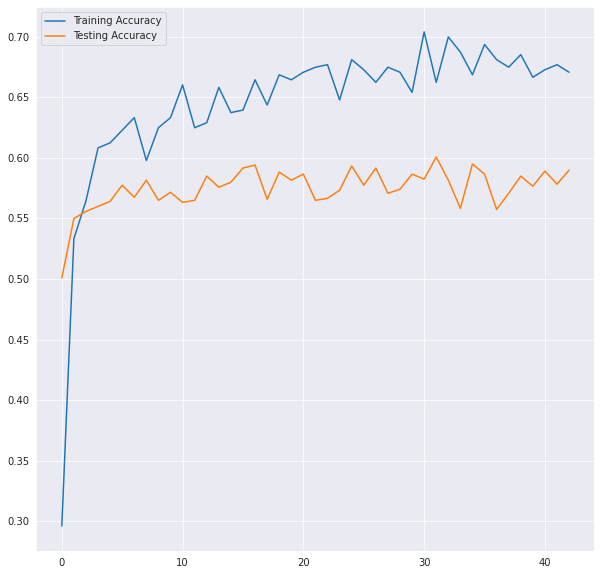

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.6041666666666666


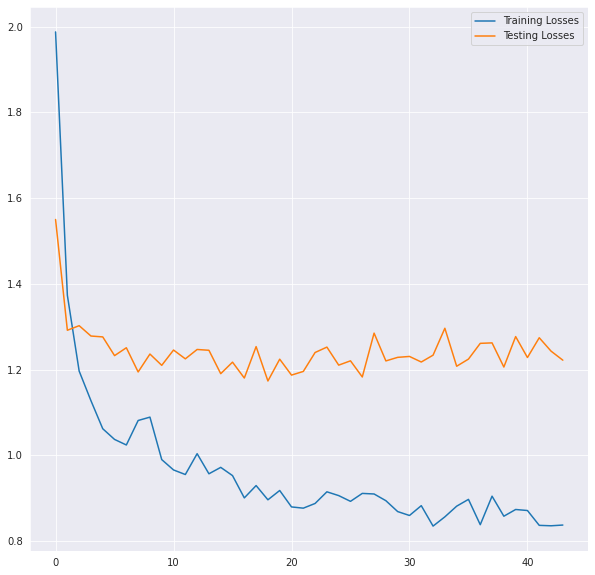

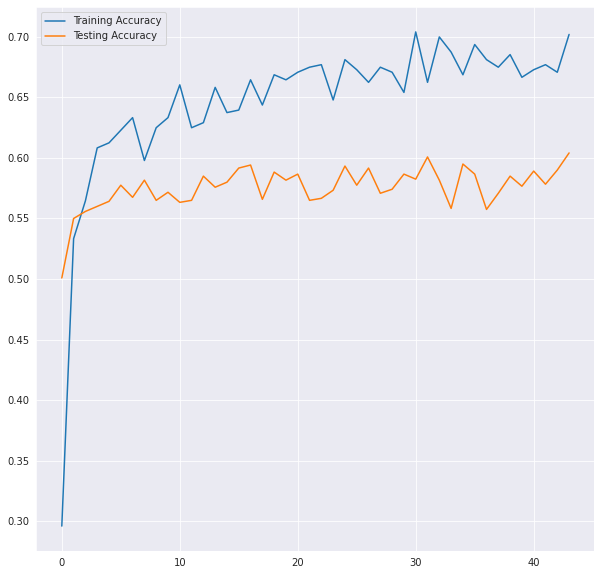

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5675


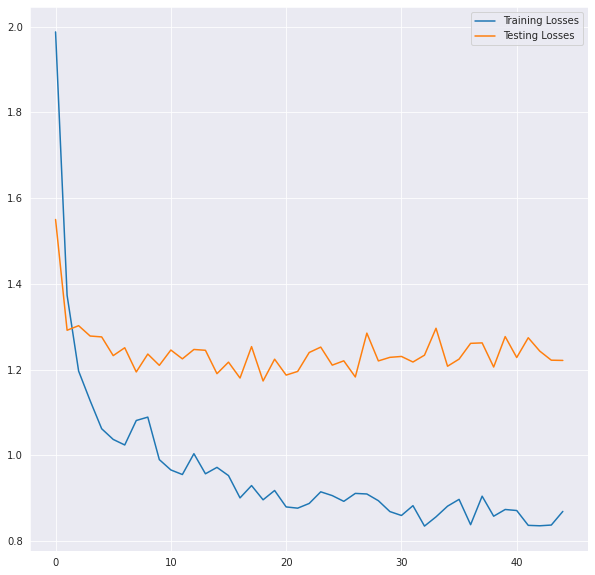

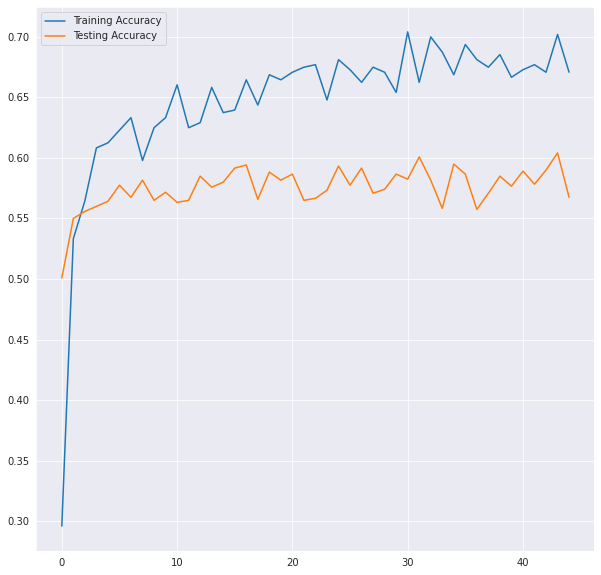

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5933333333333334


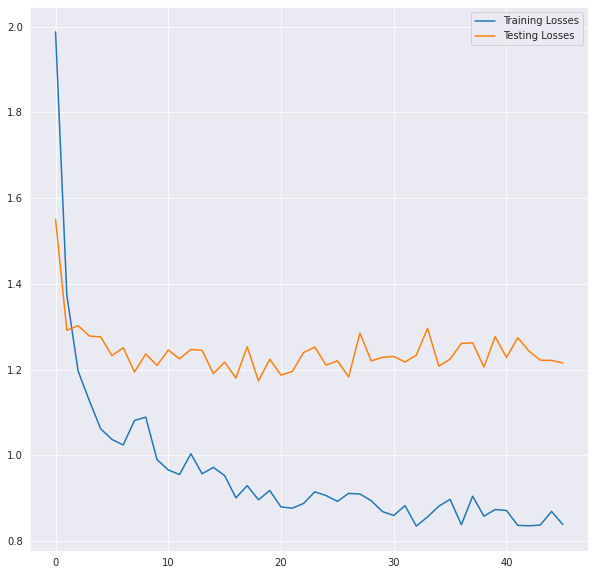

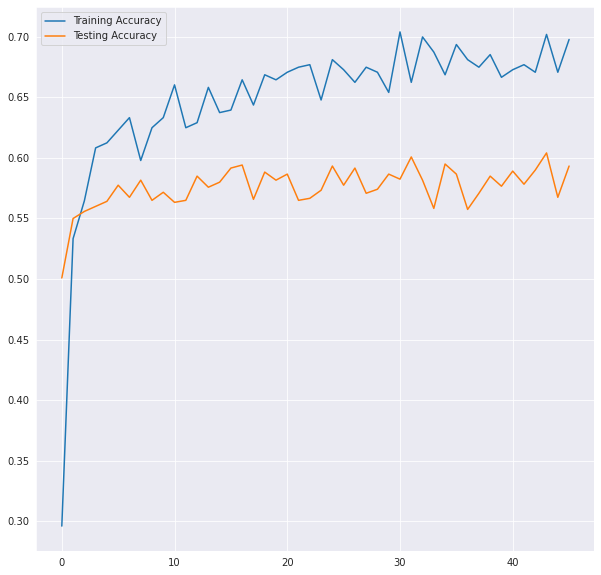

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5908333333333333


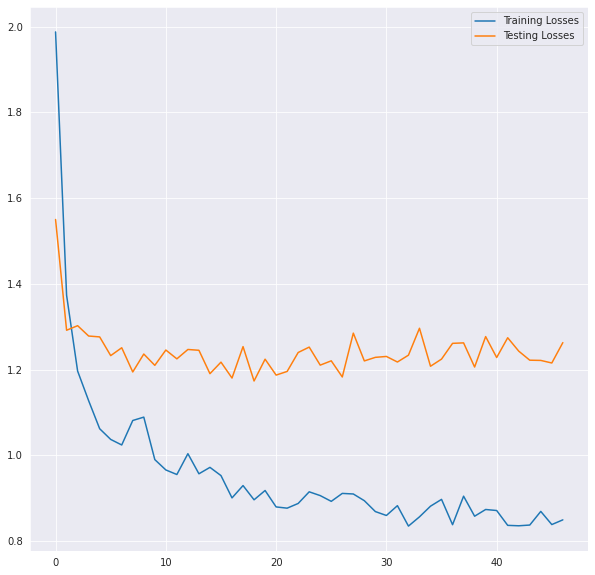

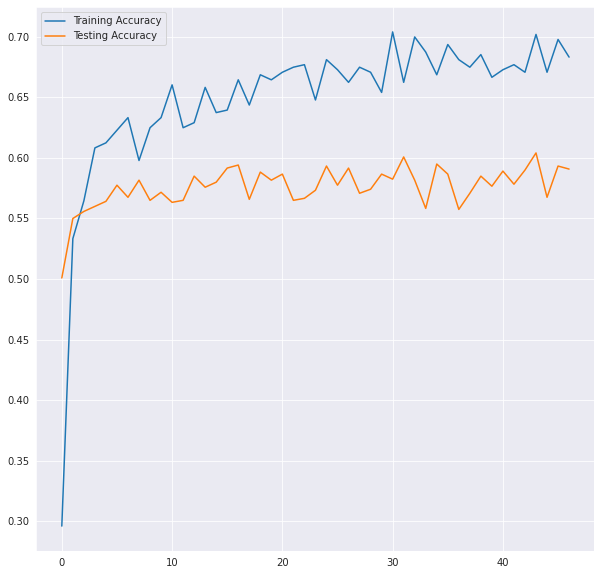

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5908333333333333


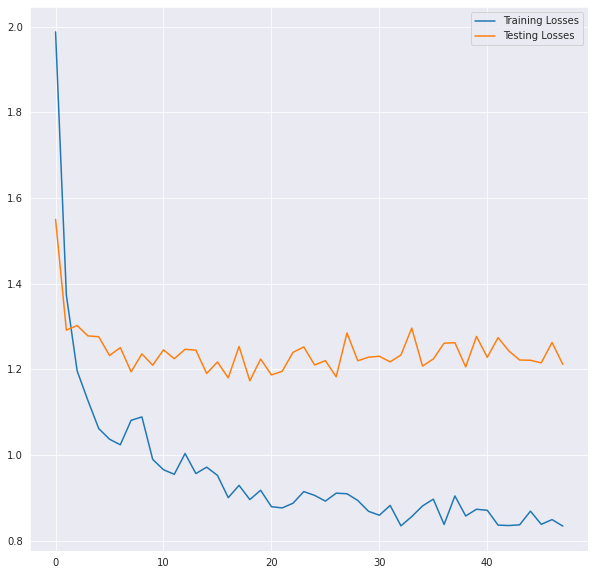

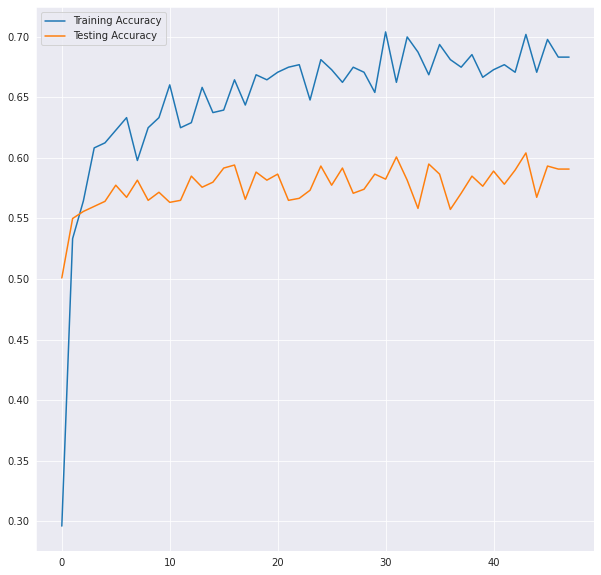

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5641666666666667


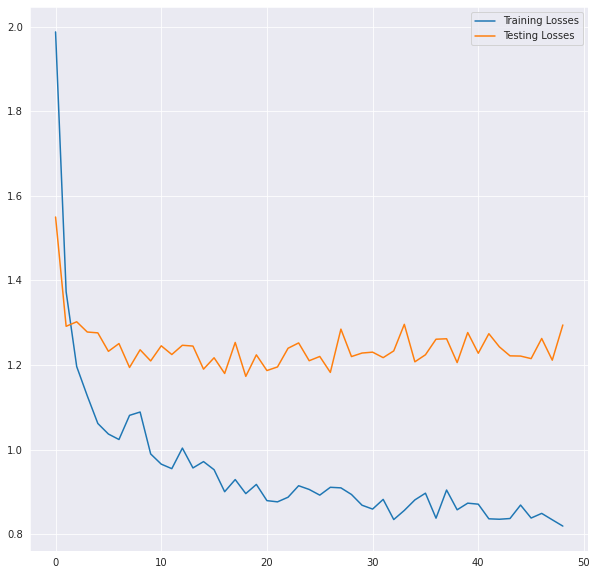

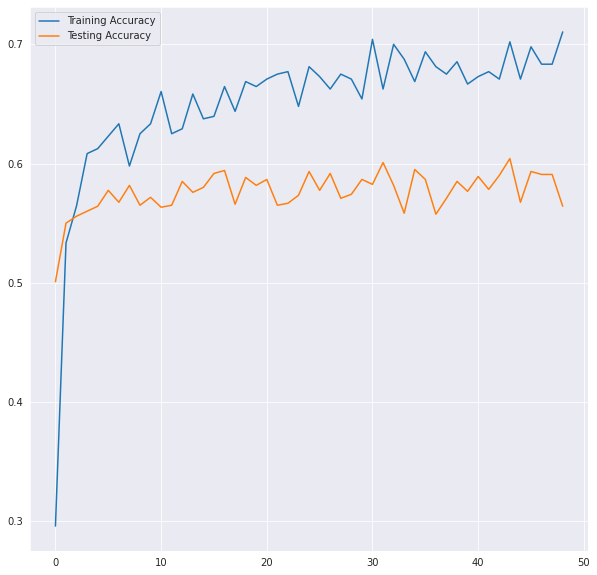

Epoch completed
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
5
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
torch.Size([48, 100])
10
0.5758333333333333


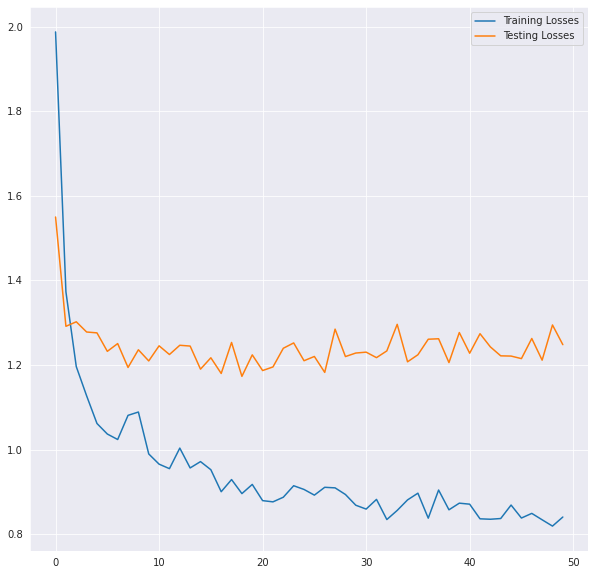

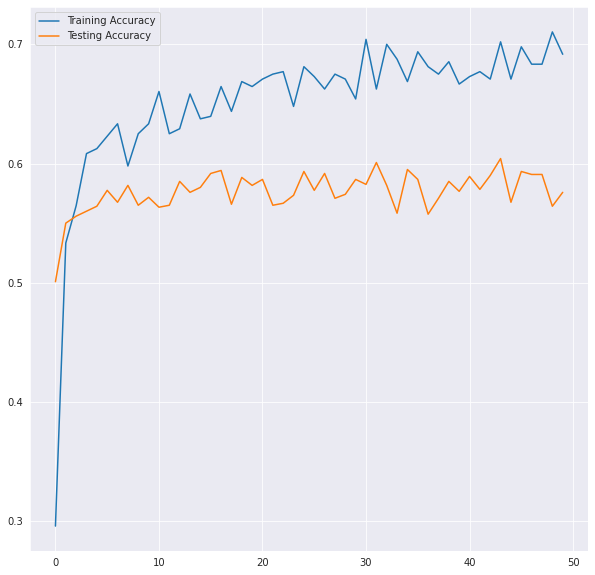

Epoch completed


In [ ]:
model._fc = nn.Sequential(*list(model._fc.children())[:-2])
model._fc = nn.Sequential(*list(model._fc.children())[:-1])

# Boolean variable to control whether to train the linear classifier or not
LINEAR = True

def get_mean_of_list(L):
    return sum(L) / len(L)

class LinearNet(nn.Module):

    def __init__(self):
        super(LinearNet, self).__init__()
        self.fc1 = torch.nn.Linear(100, 10)

    def forward(self, x):
        x = self.fc1(x)
        return(x)

if LINEAR:    

    # getting our linear classifier
    linear_classifier = LinearNet()

    # moving it to device
    linear_classifier.to(device)

    # using SGD as a linear optimizer
    linear_optimizer = optim.SGD(linear_classifier.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-6)

    #number of epochs
    num_epochs_linear = 50

    # Boolean variable to control training of linear classifier
    LINEAR_TRAINING = True

    # Defining data structures to store train and test info for linear classifier
    losses_train_linear = []
    acc_train_linear = []
    losses_test_linear = []
    acc_test_linear = []

    # a variable to keep track of the maximum test accuracy, will be useful to store 
    # model parameters with the best test accuracy
    max_test_acc = 0


    # Run a for loop for training the linear classifier
    for epoch in range(num_epochs_linear):

        if LINEAR_TRAINING:

            # run linear classifier in train mode
            linear_classifier.train()

            # a list to store losses for each batch in an epoch
            epoch_losses_train_linear = []
            epoch_acc_train_num_linear = 0.0
            epoch_acc_train_den_linear = 0.0
            counter = 0

            # for loop for running through each batch
            for (_, sample_batched) in enumerate(dataloader_training_dataset):

                # get x and y from the batch
                x = sample_batched['song']
                y_actual = sample_batched['label']

                # move them to the device
                x= stacker(x)
                x = x.to(device,dtype=torch.float)
                y_actual  = y_actual.to(device)

                # get output from resnet architecture
                y_intermediate = model(x)

                # zero the grad values
                linear_optimizer.zero_grad()

                # run y_intermediate through the linear classifier
                
                y_predicted = linear_classifier(y_intermediate)

                # get the cross entropy loss value
                loss = nn.CrossEntropyLoss()(y_predicted, y_actual)

                # add the obtained loss value to this list
                epoch_losses_train_linear.append(loss.data.item())
                
                # perform backprop through the loss value
                loss.backward()

                # call the linear_optimizer step function
                linear_optimizer.step()

                # get predictions and actual values to cpu  
                pred = np.argmax(y_predicted.cpu().data, axis=1)
                actual = y_actual.cpu().data

                #update the numerators and denominators of accuracy
                epoch_acc_train_num_linear += (actual == pred).sum().item()
                epoch_acc_train_den_linear += len(actual)

                x = None
                y_intermediate = None
                y_predicted = None
                sample_batched = None
                counter+=1
                if(counter%5==0):
                  print(counter)
            # update losses and acc lists    
            losses_train_linear.append(get_mean_of_list(epoch_losses_train_linear))
            acc_train_linear.append(epoch_acc_train_num_linear / epoch_acc_train_den_linear)
        
        # run linear classifier in eval mode
        linear_classifier.eval()

        # essential variables to keep track of losses and acc
        epoch_losses_test_linear = []
        epoch_acc_test_num_linear = 0.0
        epoch_acc_test_den_linear = 0.0

        # run a for loop through each batch
        for (_, sample_batched) in enumerate(dataloader_testing_dataset):
            x = sample_batched['song']
            y_actual = sample_batched['label']


            x= stacker(x)
            x = x.to(device,dtype=torch.float)
            y_actual  = y_actual.to(device)

            y_intermediate = model(x)

            y_predicted = linear_classifier(y_intermediate)
            loss = nn.CrossEntropyLoss()(y_predicted, y_actual)
            epoch_losses_test_linear.append(loss.data.item())

            pred = np.argmax(y_predicted.cpu().data, axis=1)
            actual = y_actual.cpu().data
            epoch_acc_test_num_linear += (actual == pred).sum().item()
            epoch_acc_test_den_linear += len(actual)

        # calculate test_acc
        test_acc = epoch_acc_test_num_linear / epoch_acc_test_den_linear
        print(test_acc)

        if LINEAR_TRAINING:
            losses_test_linear.append(get_mean_of_list(epoch_losses_test_linear))
            acc_test_linear.append(epoch_acc_test_num_linear / epoch_acc_test_den_linear)

            # plotting losses and accuracies

            fig = plt.figure(figsize=(10, 10))
            sns.set_style('darkgrid')
            plt.plot(losses_train_linear)
            plt.plot(losses_test_linear)
            plt.legend(['Training Losses', 'Testing Losses'])
            plt.show()
            

            fig = plt.figure(figsize=(10, 10))
            sns.set_style('darkgrid')
            plt.plot(acc_train_linear)
            plt.plot(acc_test_linear)
            plt.legend(['Training Accuracy', 'Testing Accuracy'])
            plt.show()
            plt.close()

            print("Epoch completed")
            

      

